# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# fix working dir
import pathlib
import os

path = os.path.join(pathlib.Path().absolute(), '../')
os.chdir(path)

In [3]:
# imports
import datetime
from pyspark.sql import SparkSession
import pydeequ
import pandas as pd
import seaborn as sns

In [4]:
# display config
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 200)
sns.set_theme(style="darkgrid")

In [5]:
# spark context
spark = (
    SparkSession
    .builder
    .config("spark.sql.session.timeZone", "UTC")
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .appName('thoth')
    .getOrCreate()
)

Ivy Default Cache set to: /home/thoth/.ivy2/cache
The jars for the packages stored in: /home/thoth/.ivy2/jars
:: loading settings :: url = jar:file:/home/thoth/.local/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
com.amazon.deequ#deequ added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-133fade2-dad3-4b7d-a2f8-d35ddee5ab40;1.0
	confs: [default]
	found com.amazon.deequ#deequ;1.2.2-spark-3.0 in central
	found org.scalanlp#breeze_2.12;0.13.2 in central
	found org.scalanlp#breeze-macros_2.12;0.13.2 in central
	found org.scala-lang#scala-reflect;2.12.1 in central
	found com.github.fommil.netlib#core;1.1.2 in central
	found net.sf.opencsv#opencsv;2.3 in central
	found com.github.rwl#jtransforms;2.4.0 in central
	found junit#junit;4.8.2 in central
	found org.apache.commons#commons-math3;3.2 in central
	found org.spire-math#spire_2.12;0.13.0 in central
	found org.spire-math#spire-macros_2.12;0.13.0 in ce

In [6]:
# logs
from thoth import logging
logging.set_logging_config()

# Generate Dataset

In [7]:
from thoth.testing.dataset_generation import (
    BatchDatasetGenerator,
    IdFeatureGenerator,
    TimestampFeatureGenerator,
    NumericFeatureGenerator,
    TimeSensitiveNumericFeatureGenerator,
    TextFeatureGenerator,
    CategoryFeatureGenerator,
    Trend,
    Seasonality,
    NormalPercentageDeviation
)

In [8]:
dataset_generator = BatchDatasetGenerator(
    # first argument model how many events (records) to generate at each timestamp granularity, in this example daily.
    events_generator=TimeSensitiveNumericFeatureGenerator(
        name="events",
        # linear trend growth
        trend=Trend(
            base_value=100,
            slope=1,
        ),
        # seasonality modeling
        seasonality=Seasonality(
            # stronger seasonality around mid-week (Wed and Thu)
            week_days=[0.85, 0.9, 1, 1, 0.9, 0.8, 0.8],
            # stronger seasonality around the beginning and the end of the month
            month_period=[1, 0.9, 1],
            # weaker seasonality around the middle of the year
            year_months=[1, 0.95, 0.9, 0.9, 0.85, 0.85, 0.85, 0.85, 0.9, 0.9, 0.95, 1],
        ),
        # uncertainty component, this attribute is optional and all numeric have this same small noise applied by default.
        noise=NormalPercentageDeviation(
            var=0.05,
            seed=123,
        )
    ),
    # after modeling the number of events to generate each day, next we model how each feature is generated
    features=[
        # basic monotonically increasing id
        IdFeatureGenerator(
            name="id",
            min_id=1000,
            monotonically_increase=True
        ),
        # random timestamp within the same day
        TimestampFeatureGenerator(
            name="ts"
        ),
        # basic numeric feature without growth and seasonality with deviation around base value
        NumericFeatureGenerator(
            name="numeric_feature",
            base_value=500,
        ),
        # numeric feature with linear trend growth without seasonality
        TimeSensitiveNumericFeatureGenerator(
            name="numeric_feature_with_trend",
            trend=Trend(
                base_value=500,
                slope=10,
            ),
        ),
        # numeric feature with strong week seasonality
        TimeSensitiveNumericFeatureGenerator(
            name="numeric_feature_with_seasonality",
            trend=Trend(
                base_value=500,
                slope=0,
            ),
            seasonality=Seasonality(
                # values drop a lot on weekends.
                week_days=[1, 1, 1, 1, 1, 0.1, 0.1],
            )
        ),
        # basic random text generator
        TextFeatureGenerator(
            name="description",
            max_base_length=120,

        ),
        # basic categorical feature equally distributed, 10% of values expected to be null but with small noise.
        CategoryFeatureGenerator(
            name="category",
            categories=["A", "B", "C", "D", "E"],
            nulls_proportion=0.2,
            nulls_proportion_noise=NormalPercentageDeviation(
                var=0.01,
                seed=123,
            ),
        )
    ]
)

In [9]:
# generated 2 years of synthetic data
dataset = dataset_generator.generate(
    start_ts=datetime.datetime(year=2018, month=1, day=1, tzinfo=datetime.timezone.utc),
    n=30  #365*2
)

In [10]:
# show dataset as pandas df
dataset_pdf = dataset_generator.to_pandas_df(dataset=dataset)
print(dataset_pdf.dtypes)
dataset_pdf

id                                                int64
ts                                  datetime64[ns, UTC]
numeric_feature                                 float64
numeric_feature_with_trend                      float64
numeric_feature_with_seasonality                float64
description                                      string
category                                         string
dtype: object


id                        ts  numeric_feature  \
0     1000 2018-01-01 11:56:30+00:00       521.157079   
1     1001 2018-01-01 21:24:05+00:00       498.078646   
2     1002 2018-01-01 05:41:34+00:00       463.144966   
3     1003 2018-01-01 07:44:14+00:00       436.834740   
4     1004 2018-01-01 12:35:01+00:00       492.235196   
...    ...                       ...              ...   
2976  3976 2018-01-30 06:16:58+00:00       514.098197   
2977  3977 2018-01-30 10:17:01+00:00       546.672040   
2978  3978 2018-01-30 05:41:05+00:00       481.817902   
2979  3979 2018-01-30 00:36:25+00:00       488.104118   
2980  3980 2018-01-30 15:59:12+00:00       471.942814   

      numeric_feature_with_trend  numeric_feature_with_seasonality  \
0                     495.023107                        479.950882   
1                     471.494105                        454.169970   
2                     504.934236                        466.981263   
3                     563.327518                        528.612581   
4                     472.234284                        506.086909   
...                          ...                               ...   
2976                  745.138841                        500.149898   
2977                  794.076024                        513.004327   
2978                  756.408226                        498.139940   
2979                  805.151760                        483.868987   
2980                  752.425293                        488.086154   

                                                                                              description  \
0       Not subject however safe recognize offer. Either scientist create call person most apply subject.   
1                          Author note through left simple. Ahead door blood whose hope Republican state.   
2       Federal teach affect wait. Oil watch increase nice. Eye society safe international dog determine.   
3                                                   Subject community ok. Paper scene yes respond indeed.   
4                          Wish store worry as seat meet benefit. Institution popular down activity rate.   
...                                                                                                   ...   
2976  Price my price thought. Glass national within lot book sing reach. Those lay job board party. Fi...   
2977                               Back necessary out save. Set government major lose. Popular last what.   
2978  Sound medical blue say. Model grow ten animal task minute economic. Indicate home energy able bl...   
2979                Compare president west purpose design executive. Walk kitchen food whose find inside.   
2980             Point these surface. Authority society on. Member street let sound. Box task know build.   

     category  
0           E  
1        <NA>  
2           C  
3           E  
4           A  
...       ...  
2976        D  
2977     <NA>  
2978        D  
2979        D  
2980        B  

[2981 rows x 7 columns]

In [11]:
# show dataset as spark df

dataset_df = dataset_generator.to_spark_df(dataset=dataset, spark=spark)
dataset_df.printSchema()
dataset_df.show(n=10)

root
 |-- id: integer (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- numeric_feature: double (nullable = true)
 |-- numeric_feature_with_trend: double (nullable = true)
 |-- numeric_feature_with_seasonality: double (nullable = true)
 |-- description: string (nullable = true)
 |-- category: string (nullable = true)



+----+-------------------+------------------+--------------------------+--------------------------------+--------------------+--------+
|  id|                 ts|   numeric_feature|numeric_feature_with_trend|numeric_feature_with_seasonality|         description|category|
+----+-------------------+------------------+--------------------------+--------------------------------+--------------------+--------+
|1000|2018-01-01 11:56:30| 521.1570794876427|         495.0231068291889|              479.95088190839414|Not subject howev...|       E|
|1001|2018-01-01 21:24:05| 498.0786456437721|          471.494104539312|                454.169970341443|Author note throu...|    null|
|1002|2018-01-01 05:41:34|463.14496632239275|        504.93423594929345|              466.98126341444606|Federal teach aff...|       C|
|1003|2018-01-01 07:44:14| 436.8347397215172|         563.3275179727757|               528.6125805784985|Subject community...|       E|
|1004|2018-01-01 12:35:01|492.23519616307107|   

# Profiling

In [12]:
from thoth import profiler

In [13]:
%%time
profiling_reports = profiler.profile(
    df=dataset_df,
    dataset="my_dataset",
    ts_column="ts",
)

[2022-05-24 20:26:42,984]::INFO::thoth.profiler.profile: 👤 Profiling started ...



[2022-05-24 20:26:46,122]::INFO::thoth.profiler.profile: Processing 30 timestamps from 2018-01-01T00:00:00 to 2018-01-30T00:00:00, with DAY granularity.



22/05/24 20:26:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[2022-05-24 20:26:55,470]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-01T00:00:00.

[2022-05-24 20:27:01,072]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-02T00:00:00.

[2022-05-24 20:27:04,081]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-03T00:00:00.

[2022-05-24 20:27:06,937]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-04T00:00:00.

[2022-05-24 20:27:09,386]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-05T00:00:00.

[2022-05-24 20:27:11,739]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-06T00:00:00.

[2022-05-24 20:27:14,329]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-07T00:00:00.

[2022-05-24 20:27:16,661]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-08T00:00:00.

[2022-05-24 20:27:19,054]::INFO::thoth.profiler._build_r

[2022-05-24 20:28:03,500]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-27T00:00:00.

[2022-05-24 20:28:05,654]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-28T00:00:00.

[2022-05-24 20:28:07,993]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-29T00:00:00.

[2022-05-24 20:28:10,164]::INFO::thoth.profiler._build_report: Finished profiling report for ts=2018-01-30T00:00:00.

[2022-05-24 20:28:10,168]::INFO::thoth.profiler.profile: 👤 Profiling done!

CPU times: user 3.04 s, sys: 1.74 s, total: 4.77 s
Wall time: 1min 27s


In [14]:
# showing computed profiling metrics
profiling_reports[-1].get_metrics()

{Metric(entity='Column', instance='category', name='Completeness'),
 Metric(entity='Column', instance='category', name='CountDistinct'),
 Metric(entity='Column', instance='category', name='Distinctness'),
 Metric(entity='Column', instance='category', name='MaxLength'),
 Metric(entity='Column', instance='category', name='MinLength'),
 Metric(entity='Column', instance='description', name='Completeness'),
 Metric(entity='Column', instance='description', name='CountDistinct'),
 Metric(entity='Column', instance='description', name='Distinctness'),
 Metric(entity='Column', instance='description', name='MaxLength'),
 Metric(entity='Column', instance='description', name='MinLength'),
 Metric(entity='Column', instance='id', name='ApproxQuantiles-0.25'),
 Metric(entity='Column', instance='id', name='ApproxQuantiles-0.5'),
 Metric(entity='Column', instance='id', name='ApproxQuantiles-0.75'),
 Metric(entity='Column', instance='id', name='Completeness'),
 Metric(entity='Column', instance='id', name

In [15]:
# showing computed timestamps (aggregation group)
set(pr.ts for pr in profiling_reports)

{datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 1, 2, 0, 0),
 datetime.datetime(2018, 1, 3, 0, 0),
 datetime.datetime(2018, 1, 4, 0, 0),
 datetime.datetime(2018, 1, 5, 0, 0),
 datetime.datetime(2018, 1, 6, 0, 0),
 datetime.datetime(2018, 1, 7, 0, 0),
 datetime.datetime(2018, 1, 8, 0, 0),
 datetime.datetime(2018, 1, 9, 0, 0),
 datetime.datetime(2018, 1, 10, 0, 0),
 datetime.datetime(2018, 1, 11, 0, 0),
 datetime.datetime(2018, 1, 12, 0, 0),
 datetime.datetime(2018, 1, 13, 0, 0),
 datetime.datetime(2018, 1, 14, 0, 0),
 datetime.datetime(2018, 1, 15, 0, 0),
 datetime.datetime(2018, 1, 16, 0, 0),
 datetime.datetime(2018, 1, 17, 0, 0),
 datetime.datetime(2018, 1, 18, 0, 0),
 datetime.datetime(2018, 1, 19, 0, 0),
 datetime.datetime(2018, 1, 20, 0, 0),
 datetime.datetime(2018, 1, 21, 0, 0),
 datetime.datetime(2018, 1, 22, 0, 0),
 datetime.datetime(2018, 1, 23, 0, 0),
 datetime.datetime(2018, 1, 24, 0, 0),
 datetime.datetime(2018, 1, 25, 0, 0),
 datetime.datetime(2018, 1, 26, 0,

### Visualizing profiling metrics

In [16]:
from thoth.anomaly.base import convert_to_timeseries
time_series = convert_to_timeseries(history=profiling_reports)

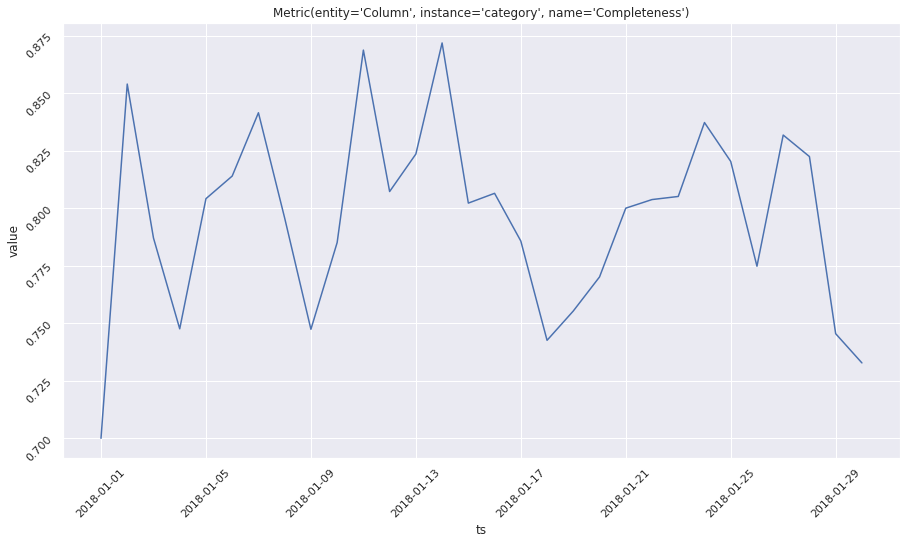

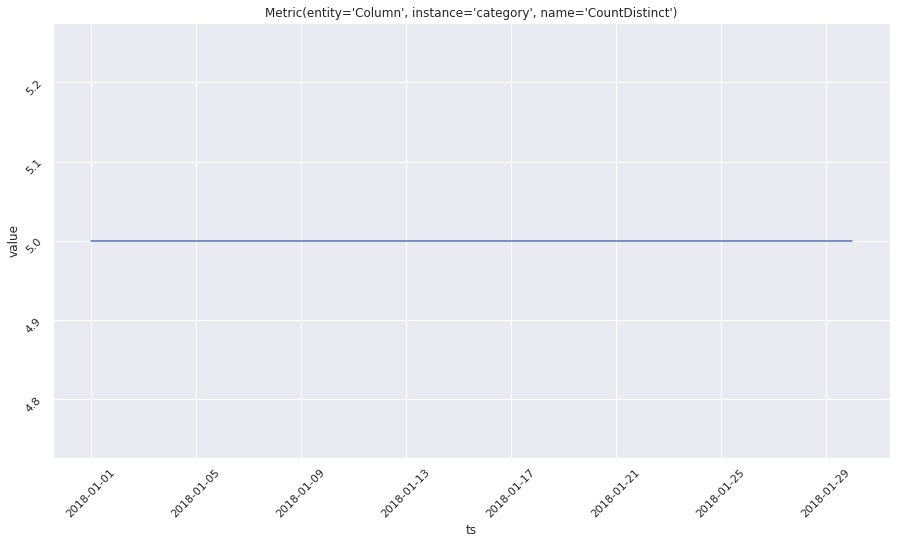

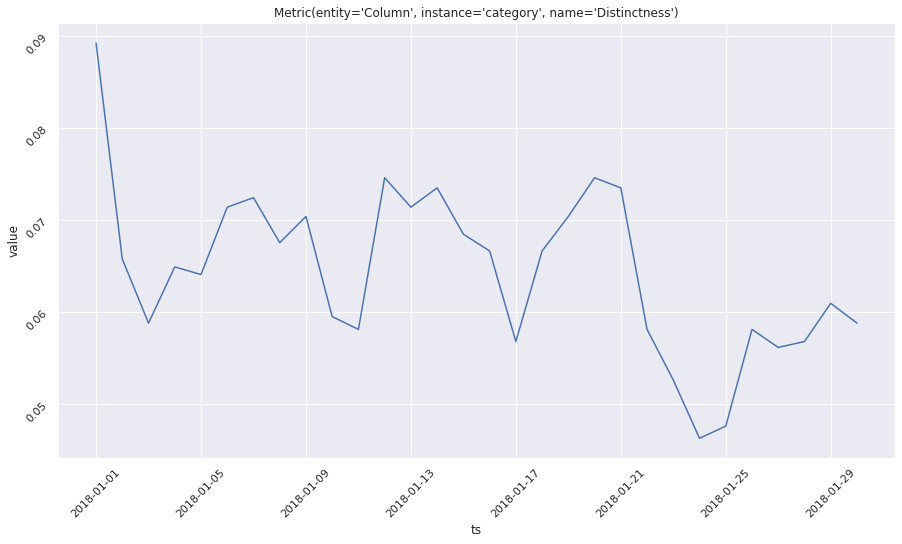

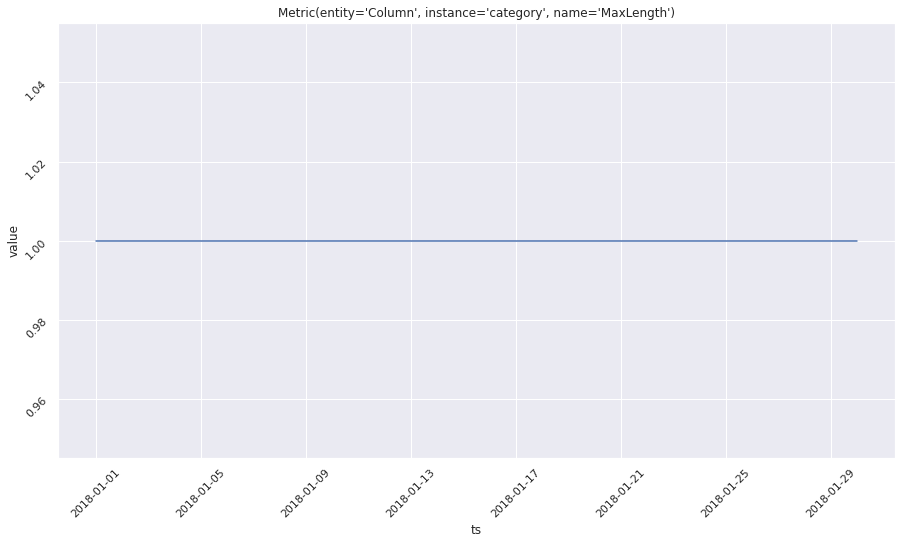

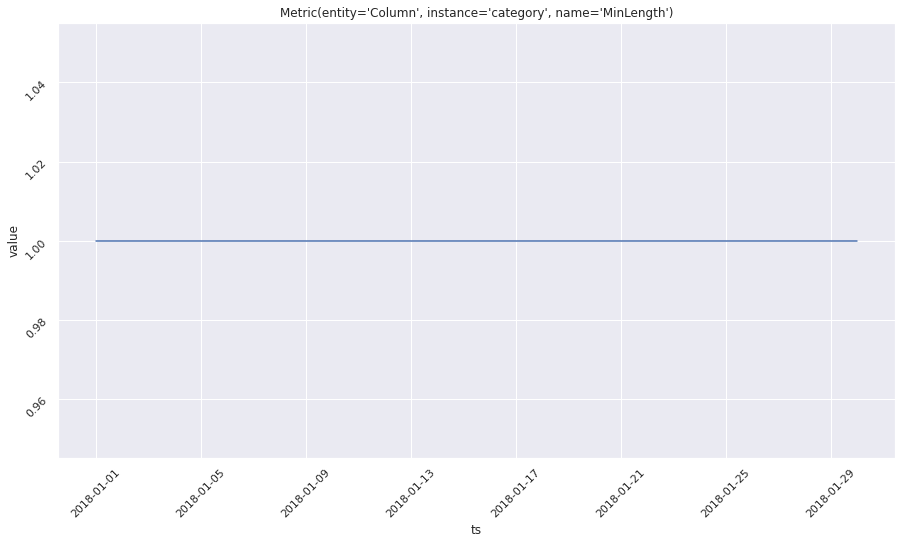

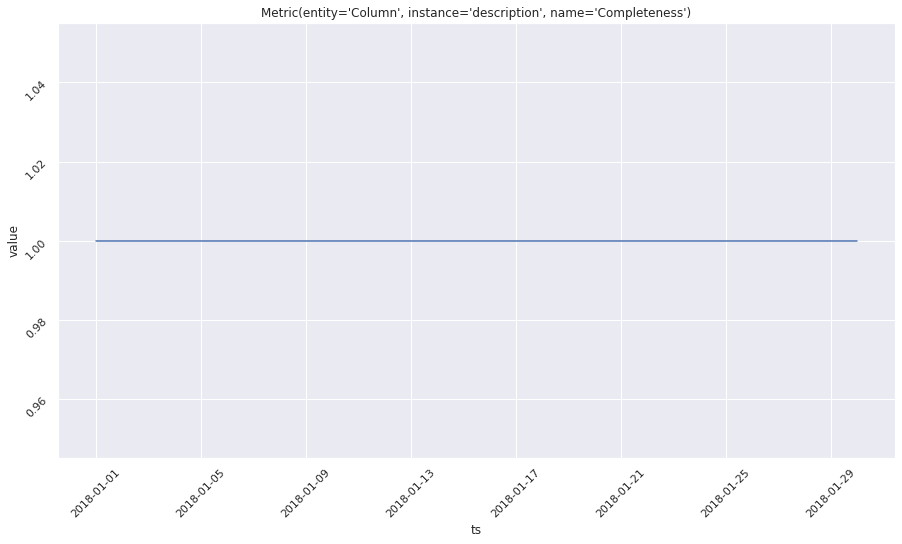

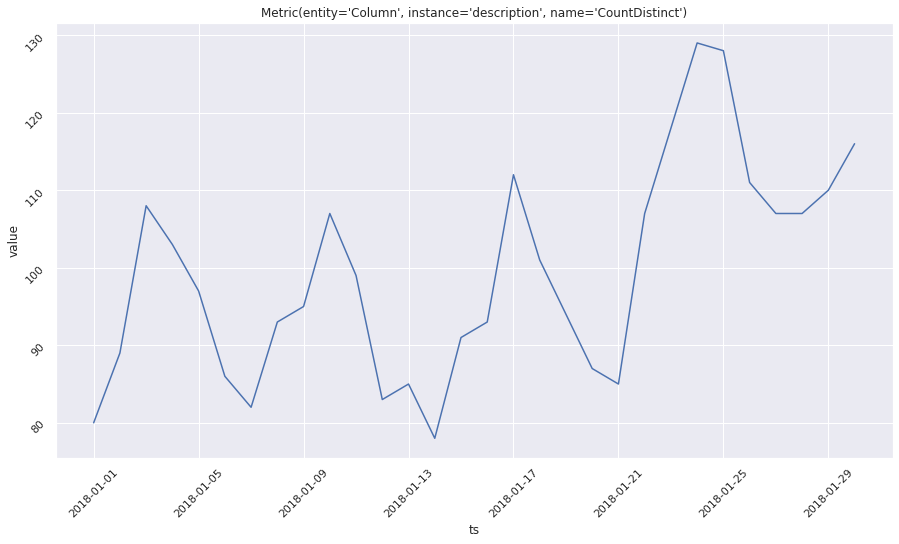

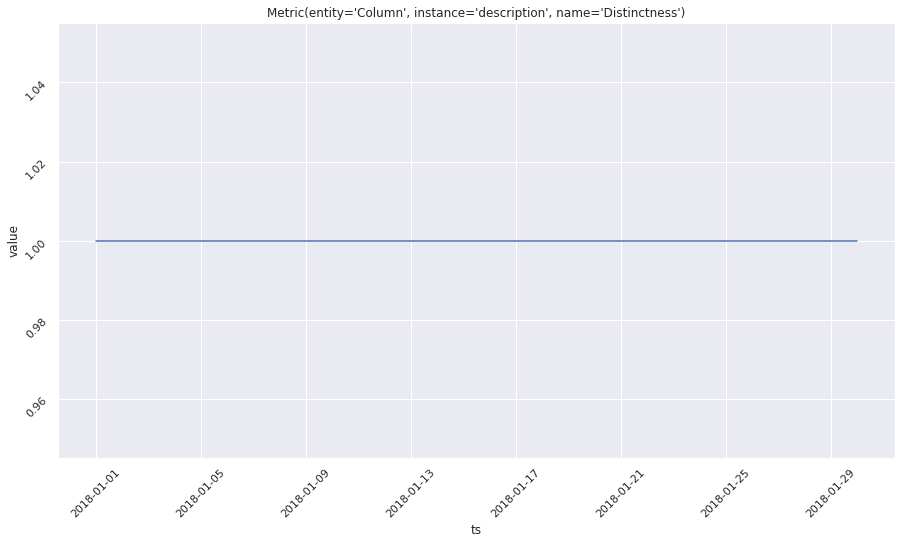

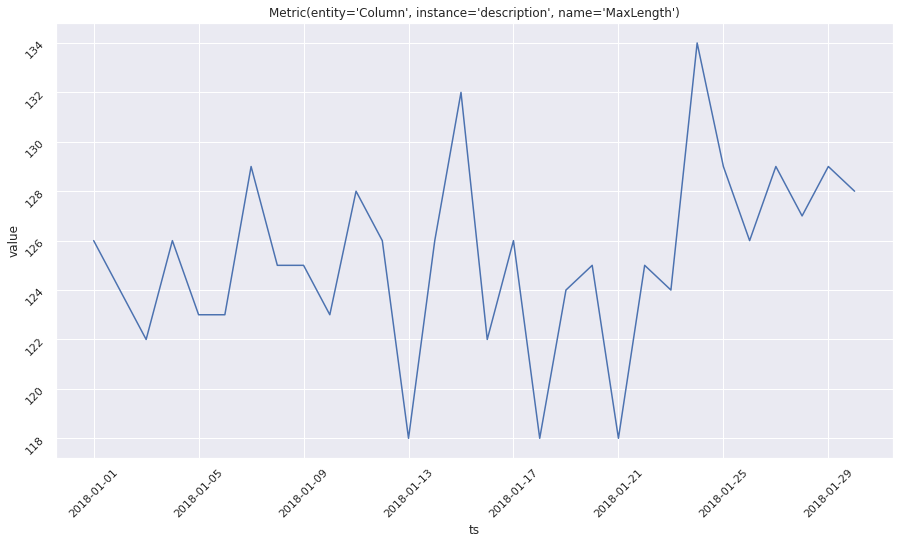

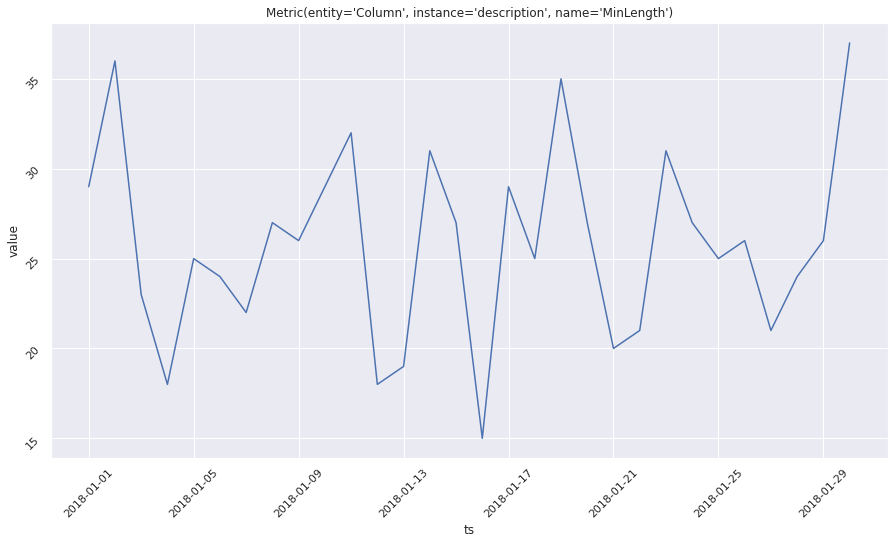

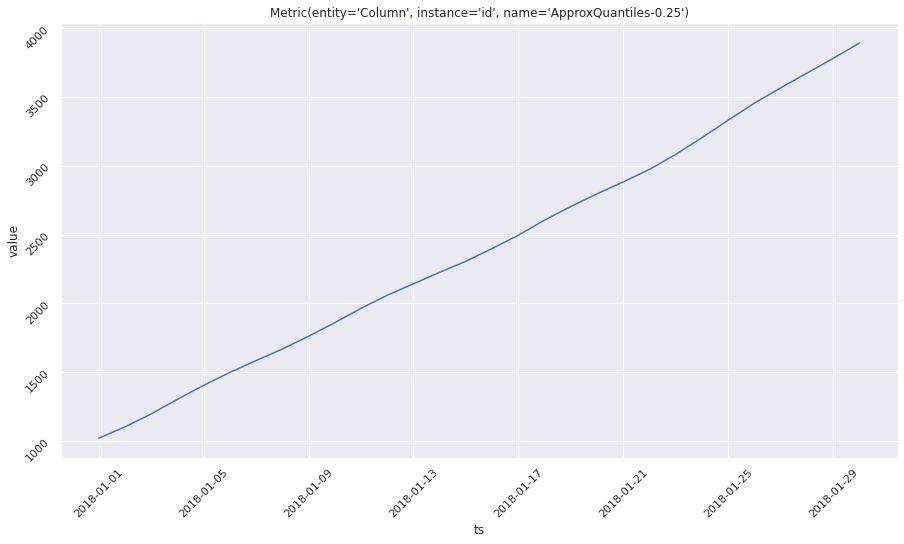

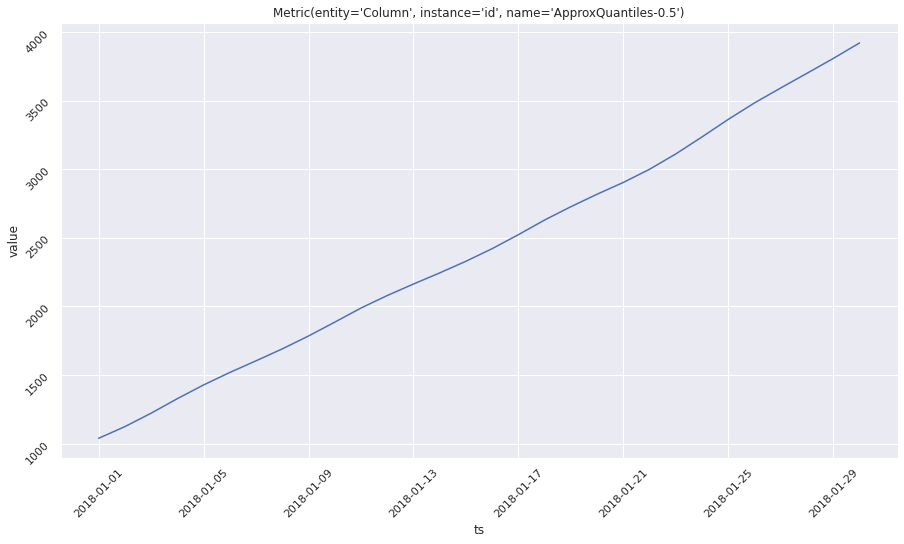

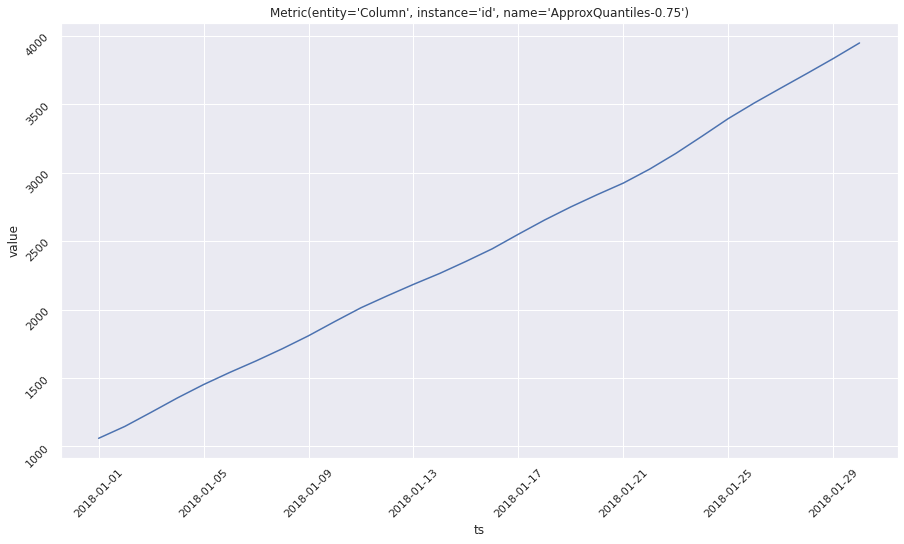

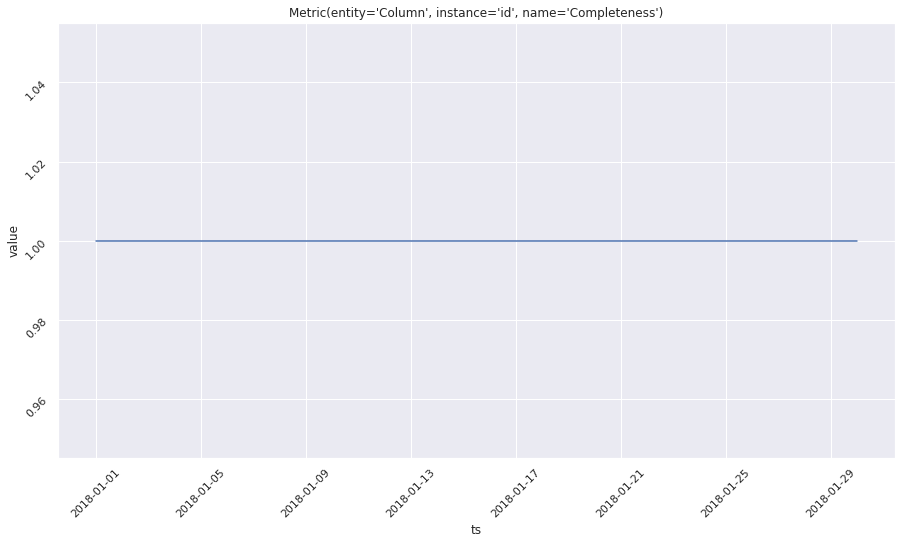

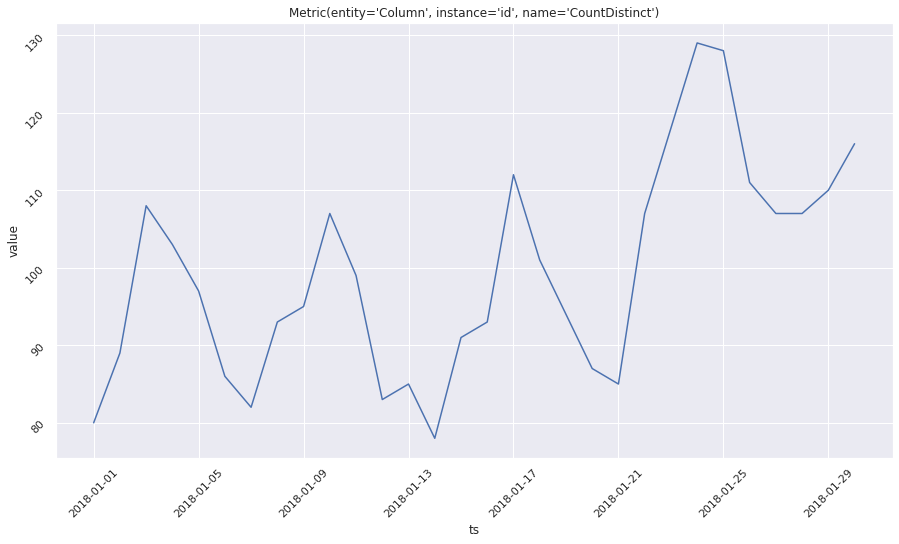

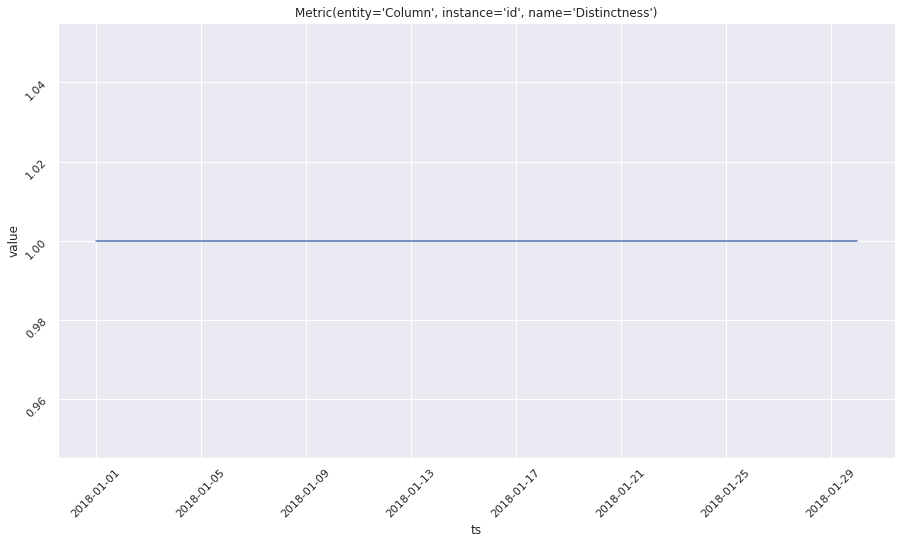

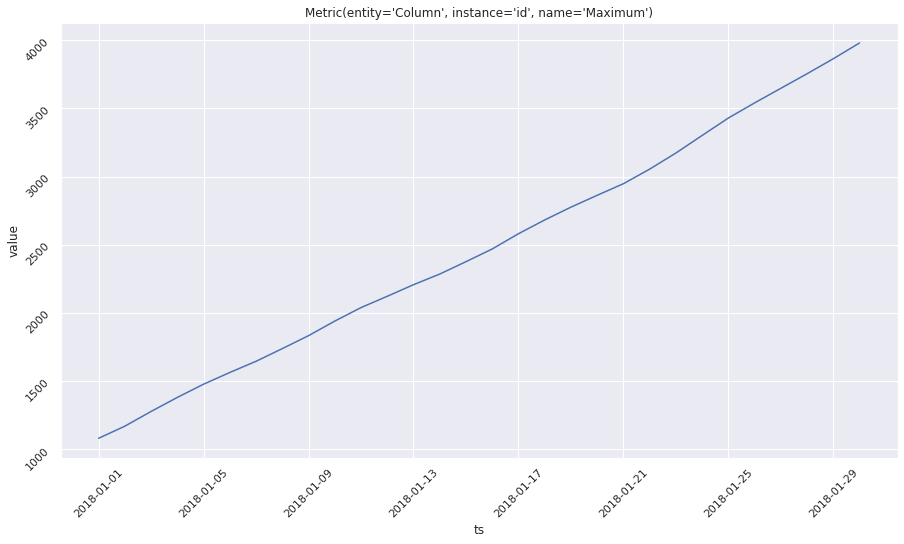

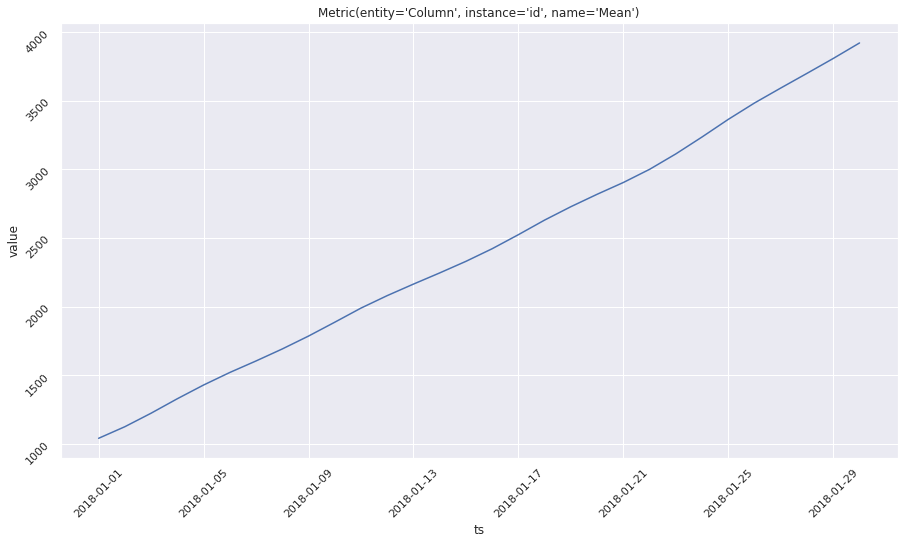

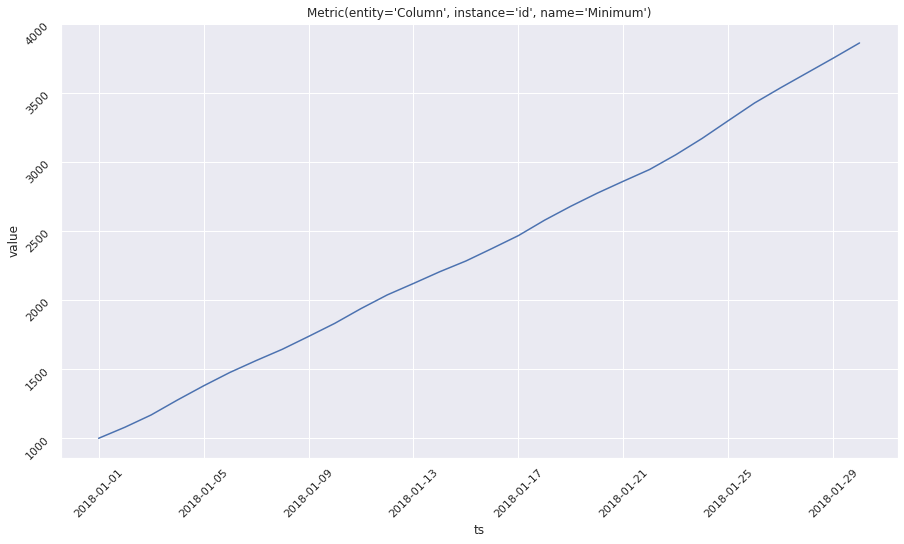

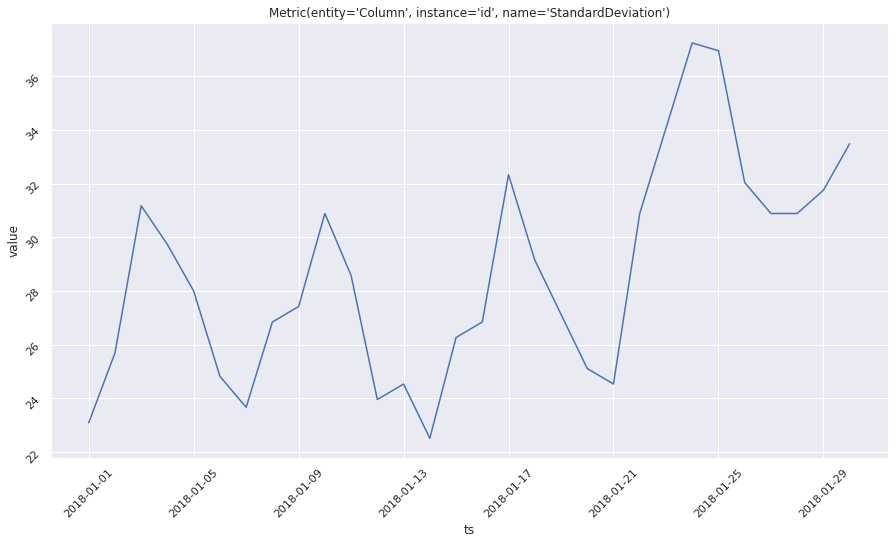

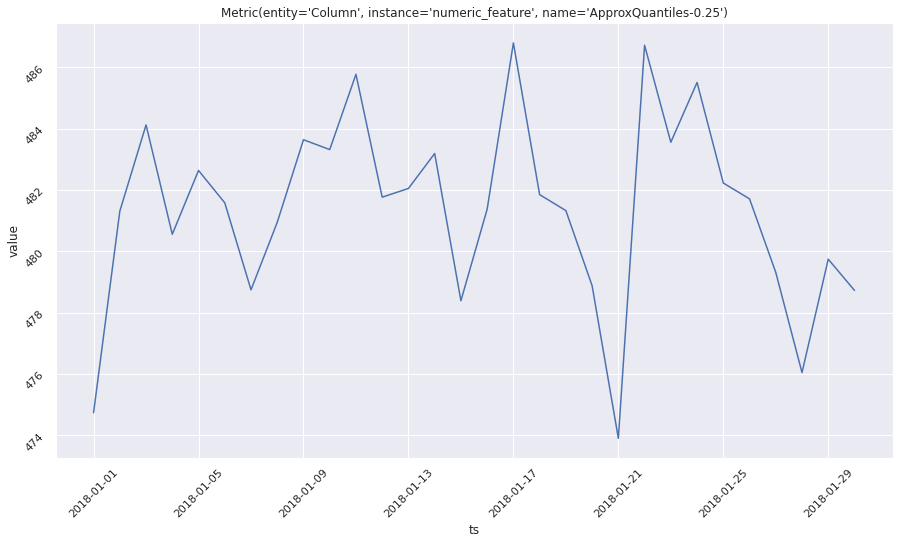

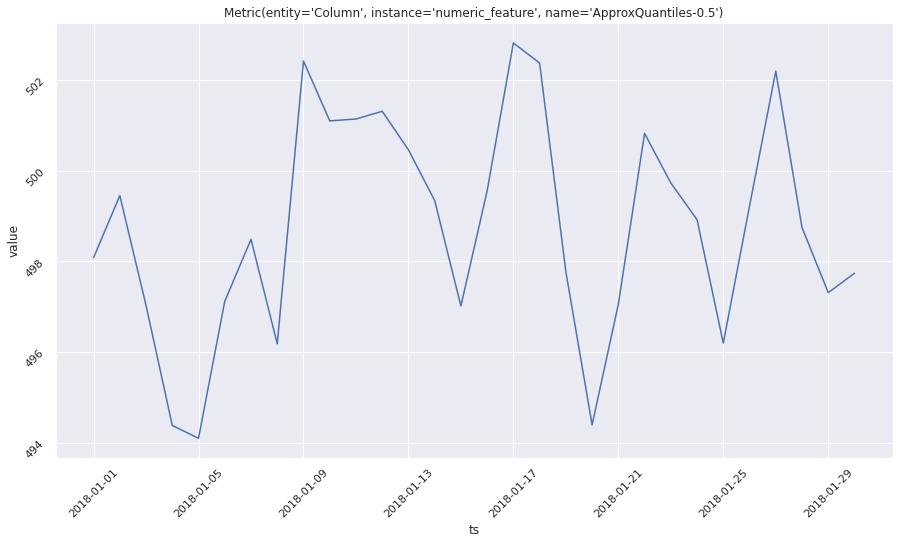

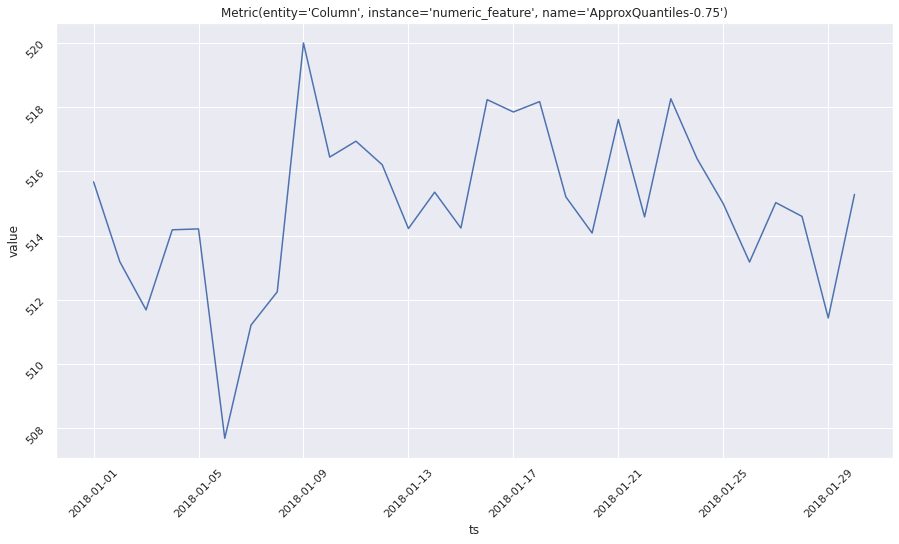

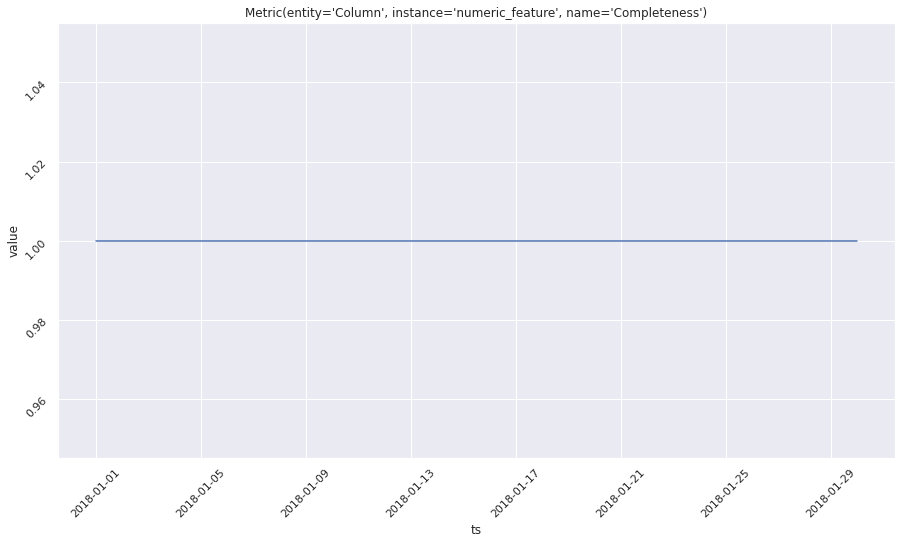

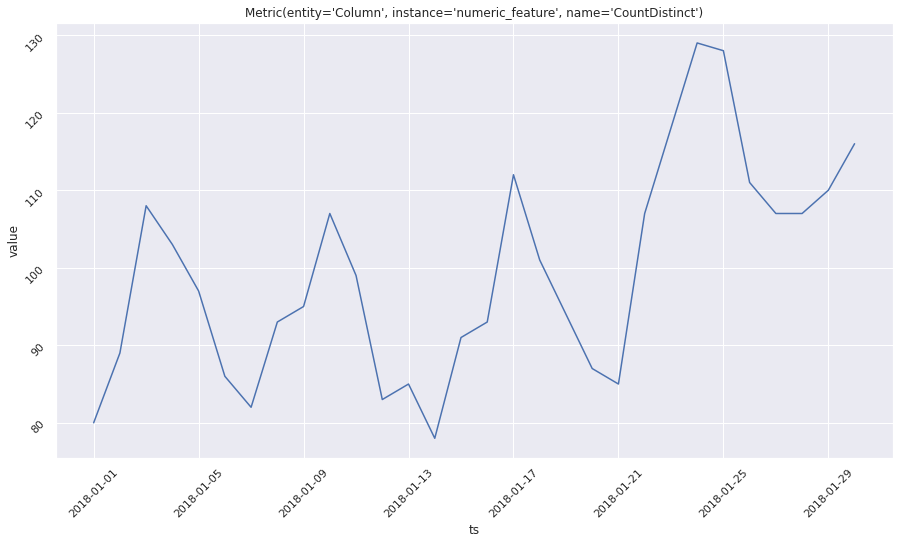

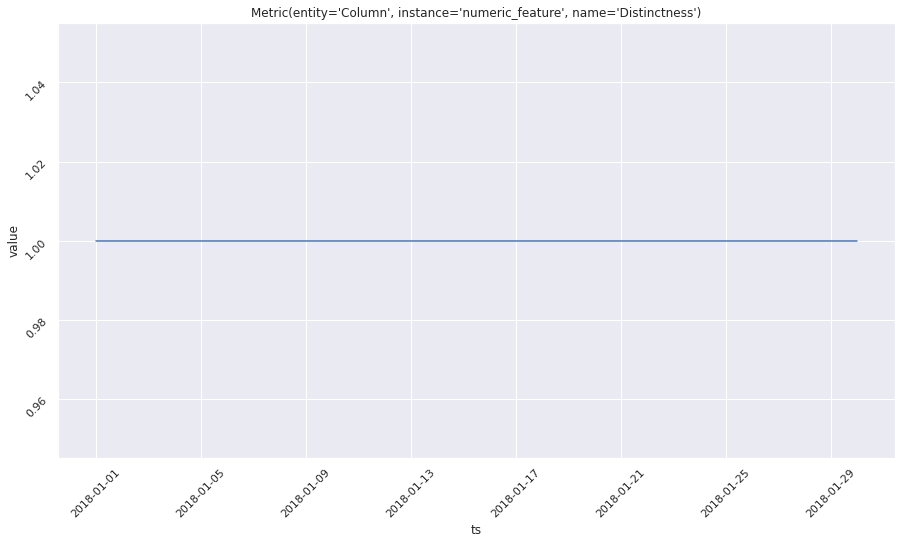

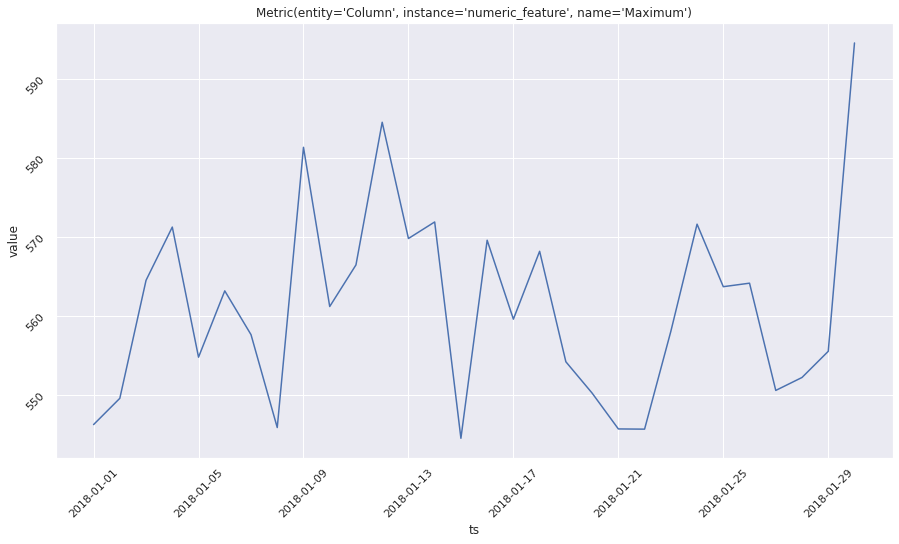

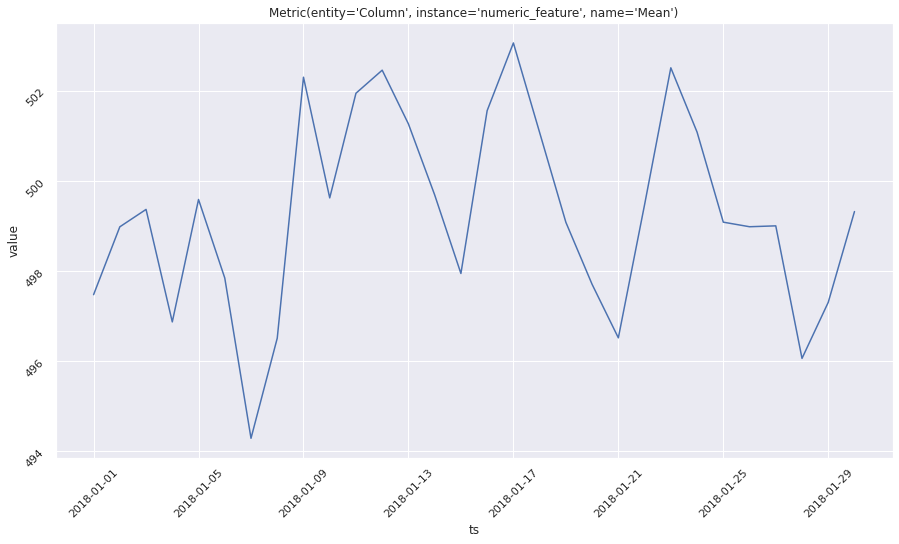

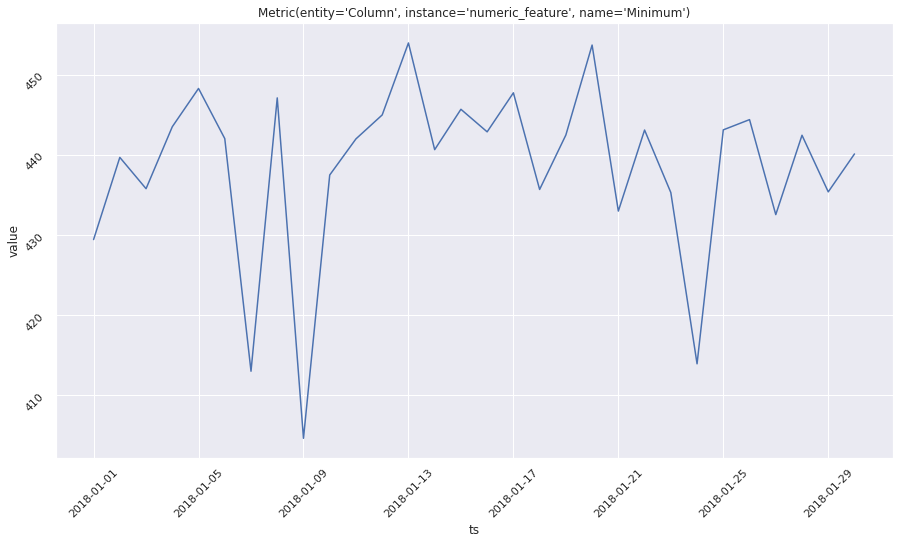

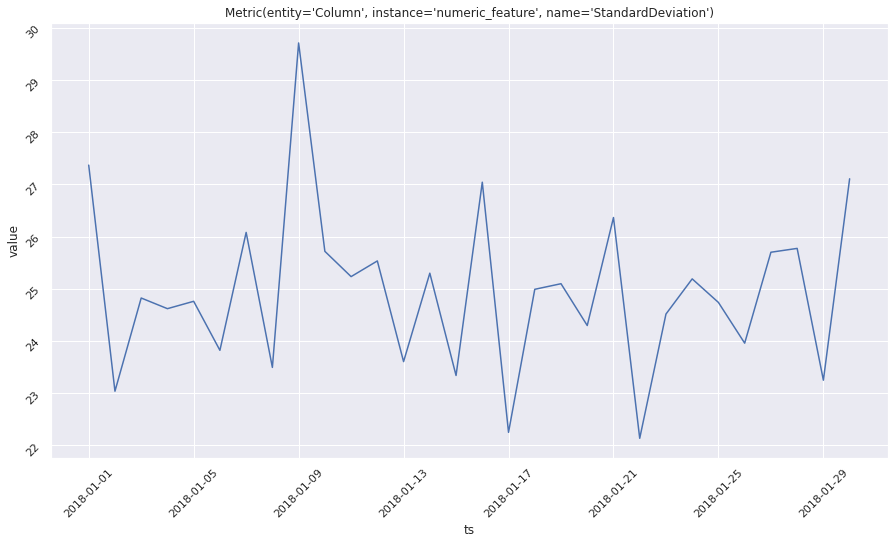

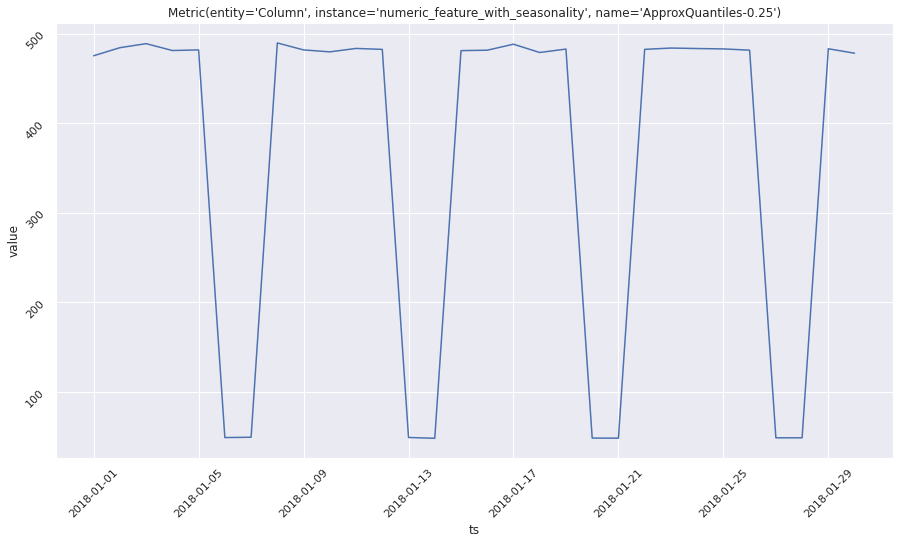

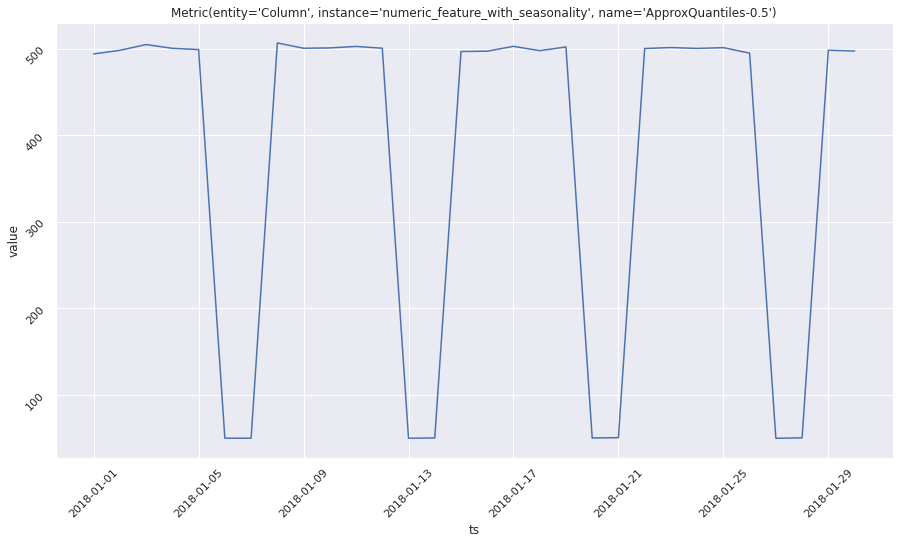

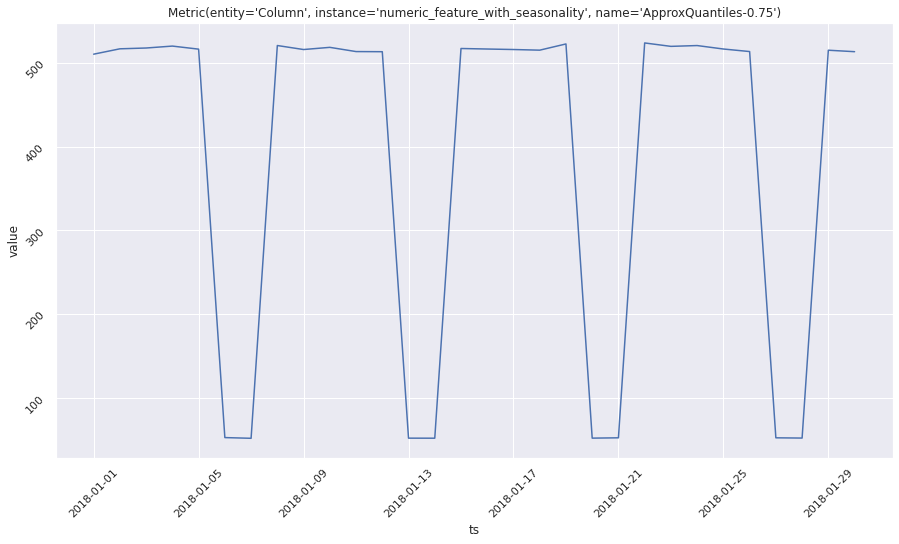

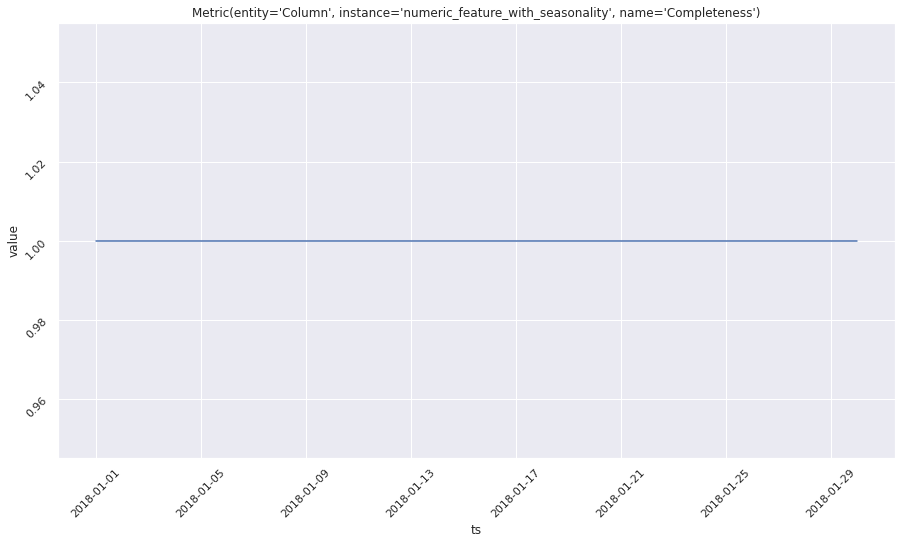

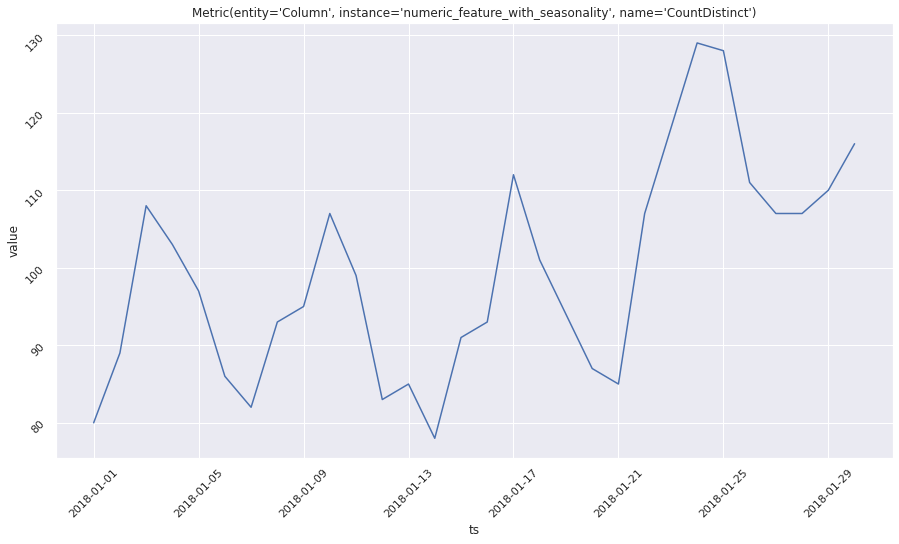

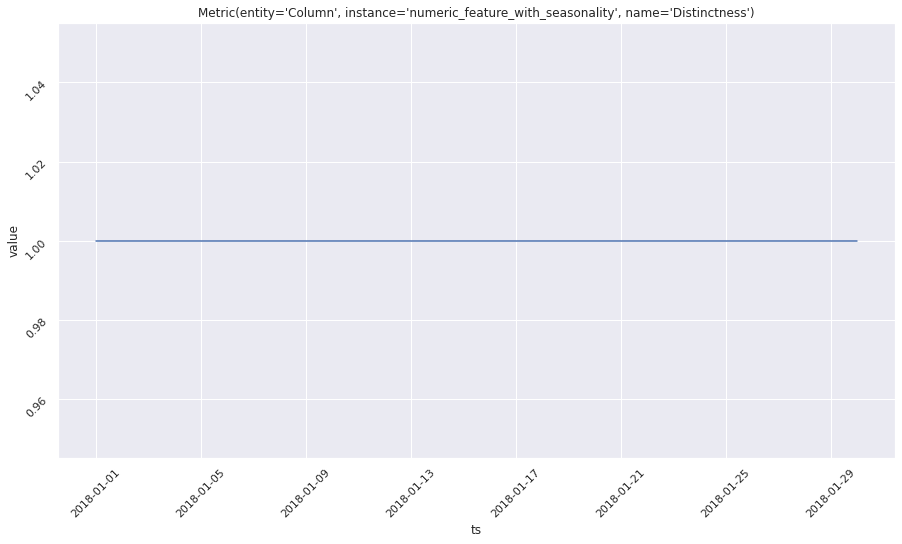

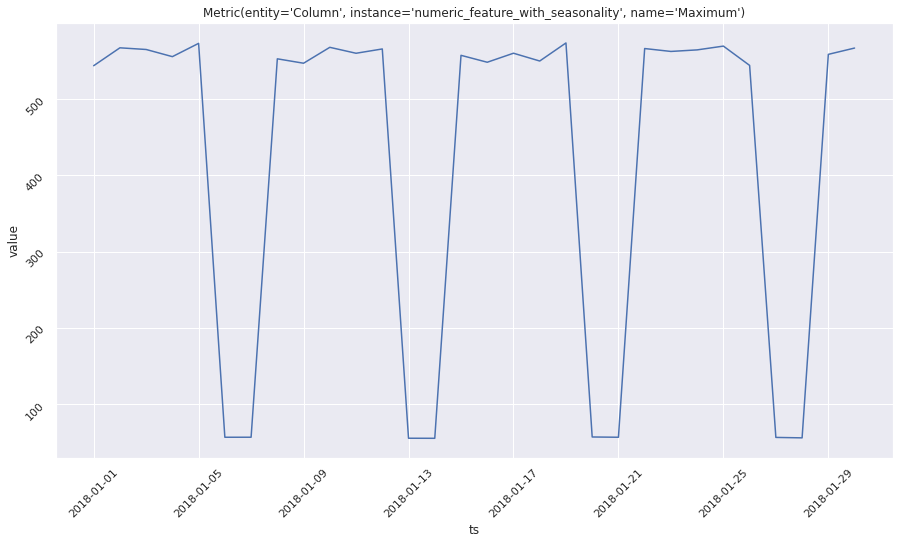

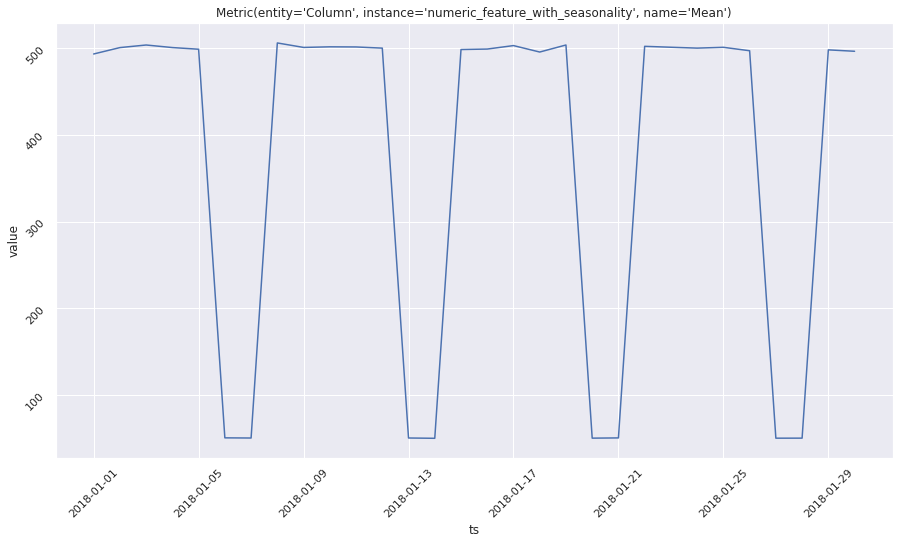

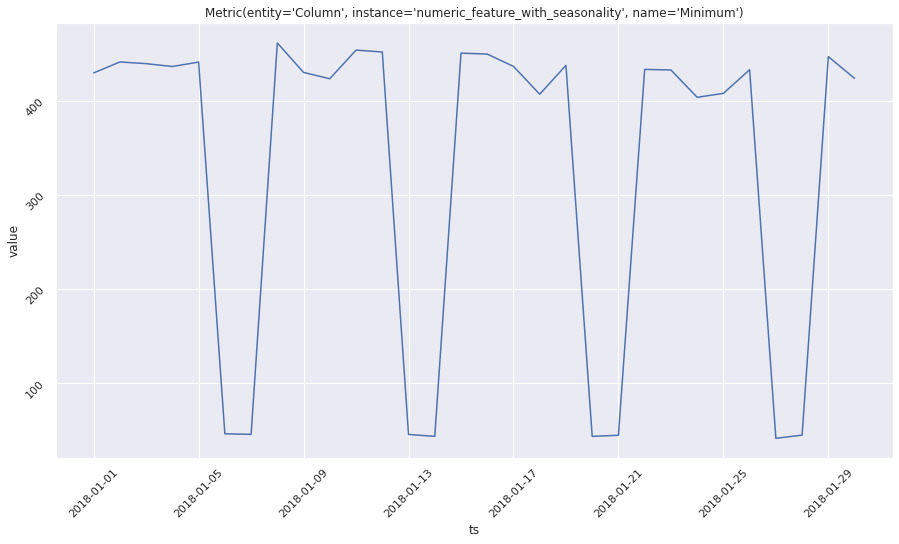

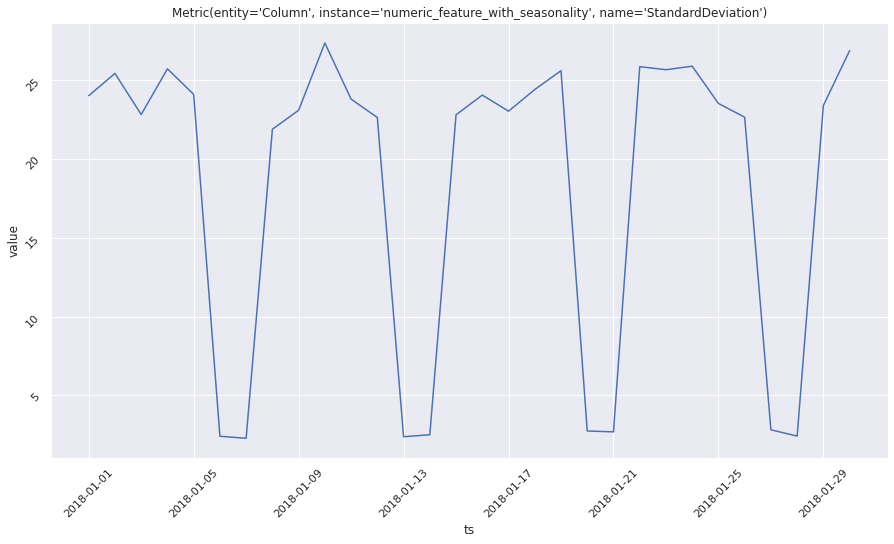

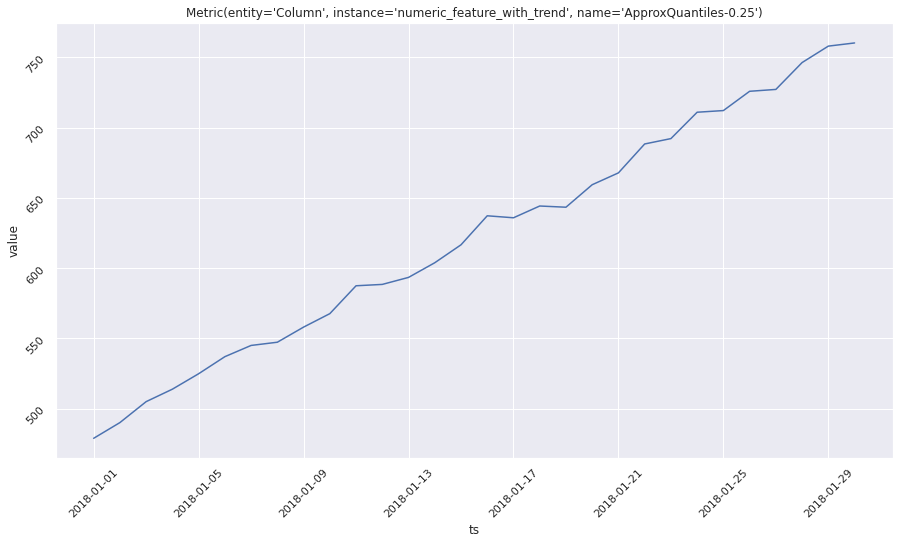

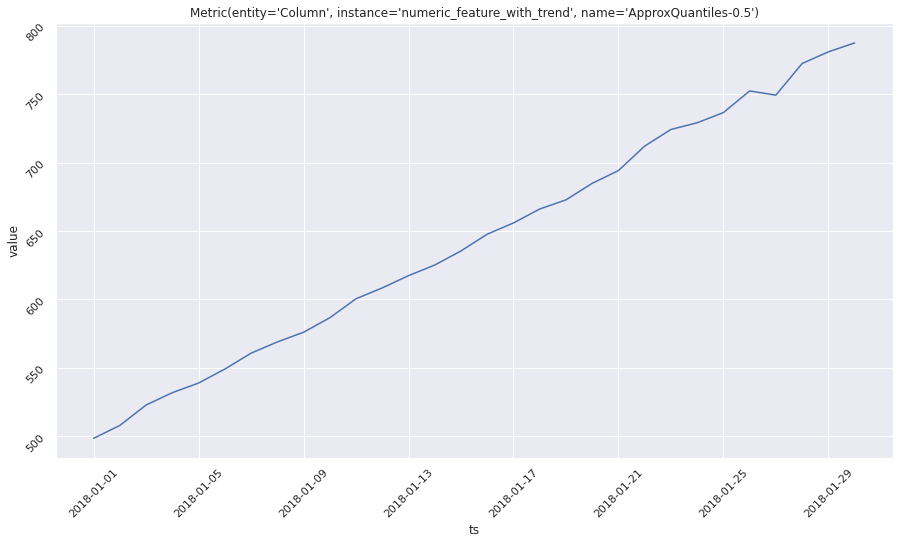

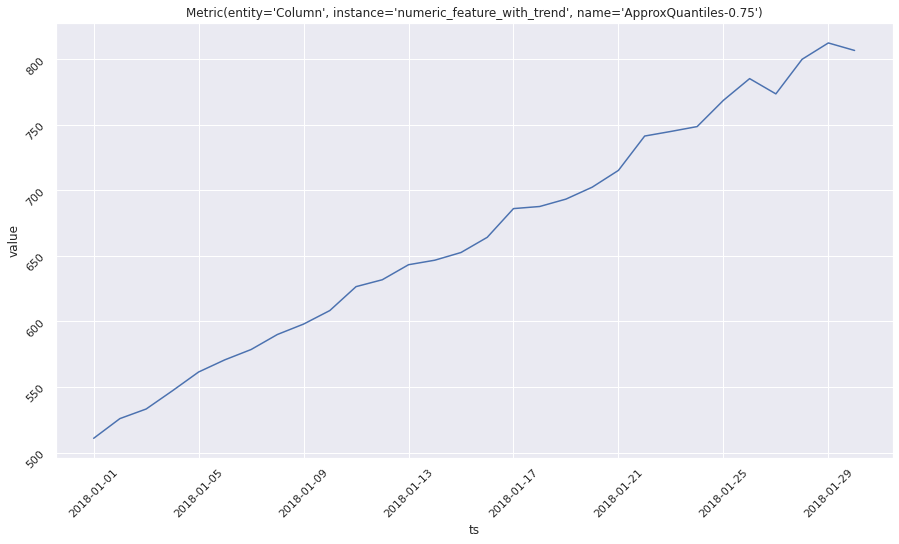

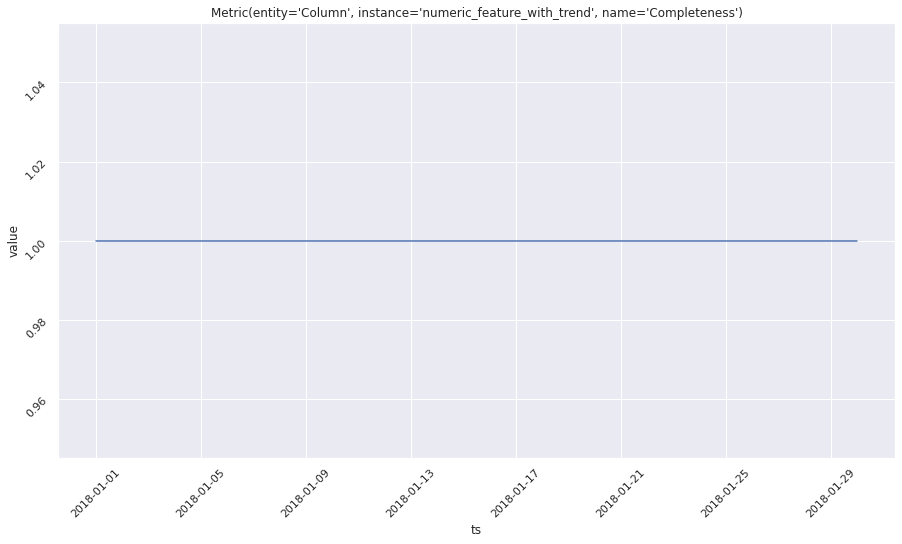

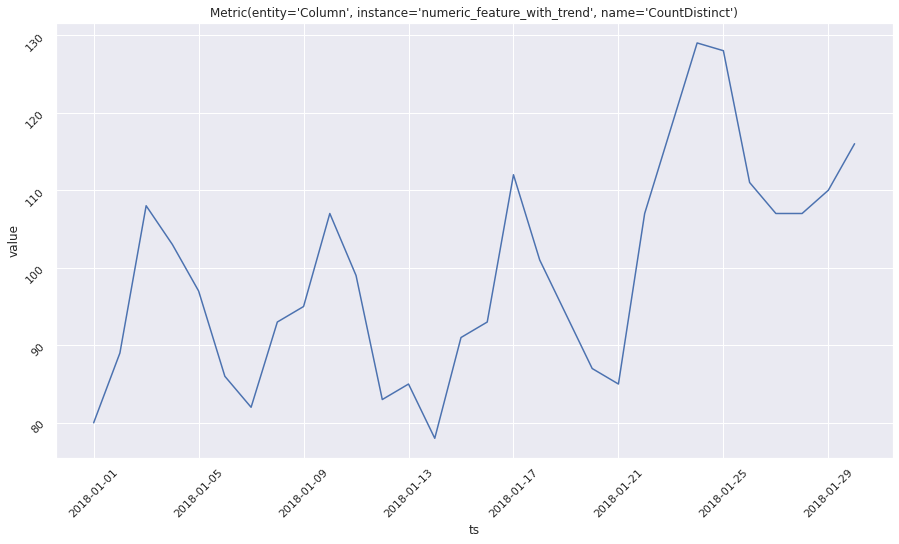

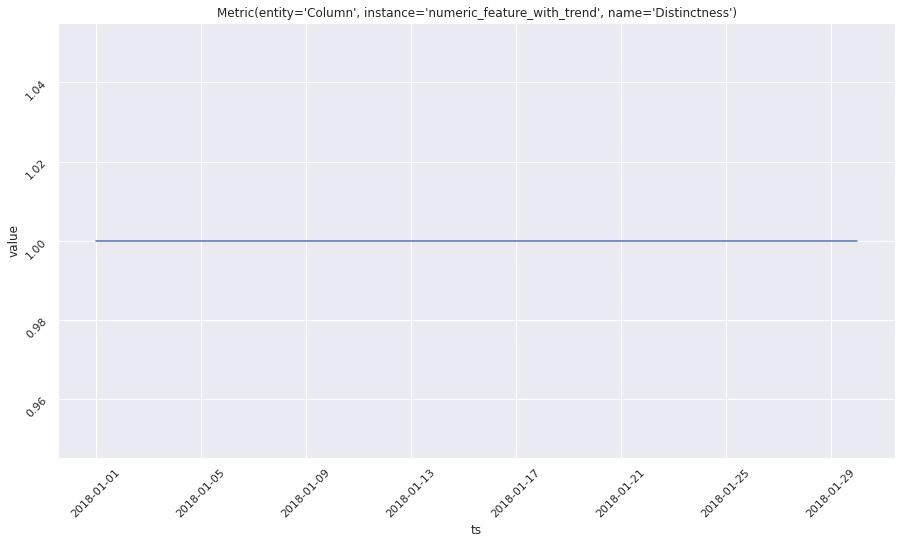

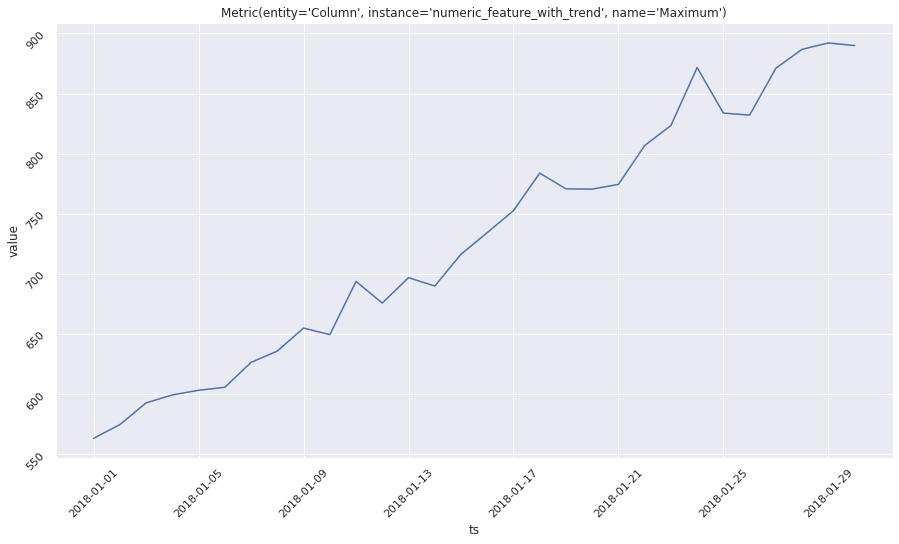

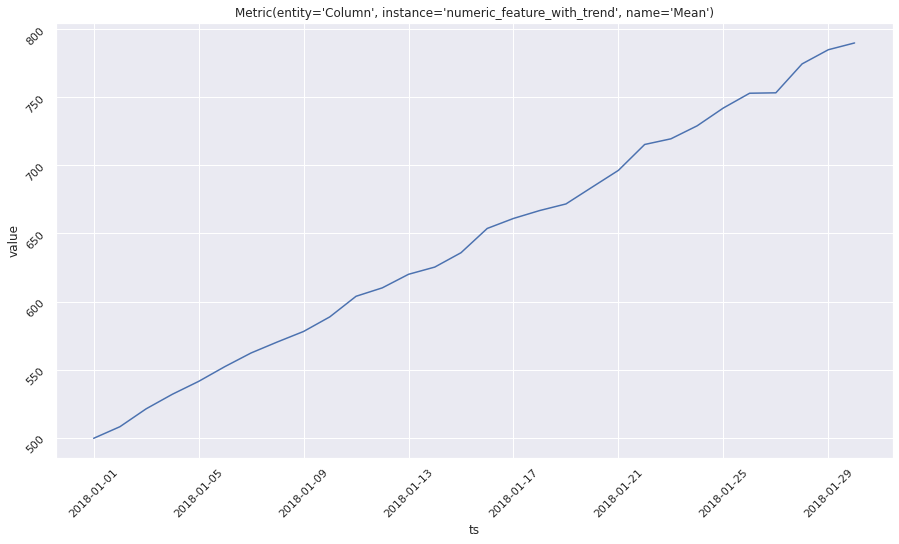

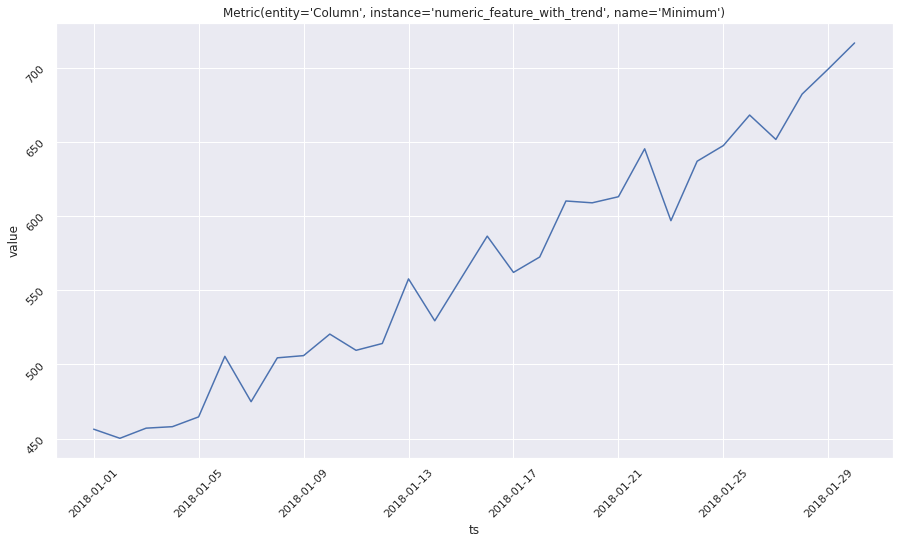

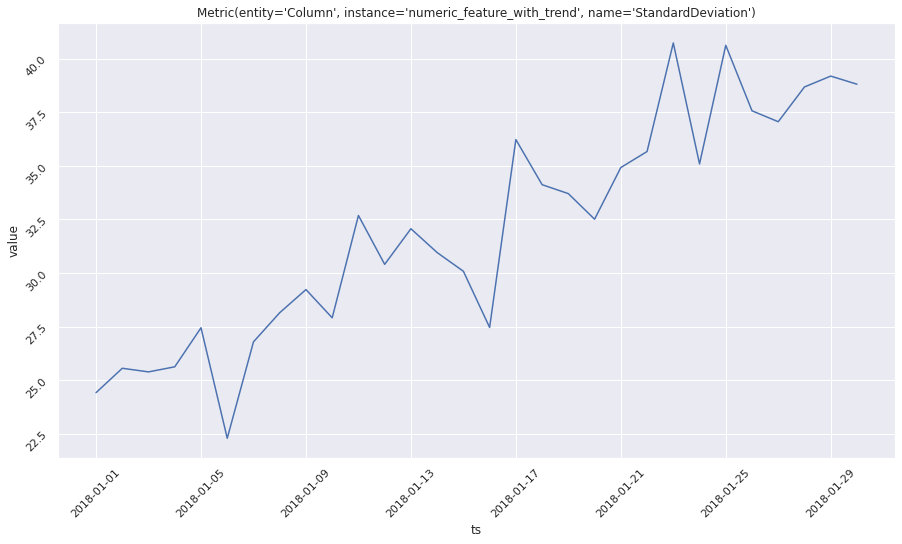

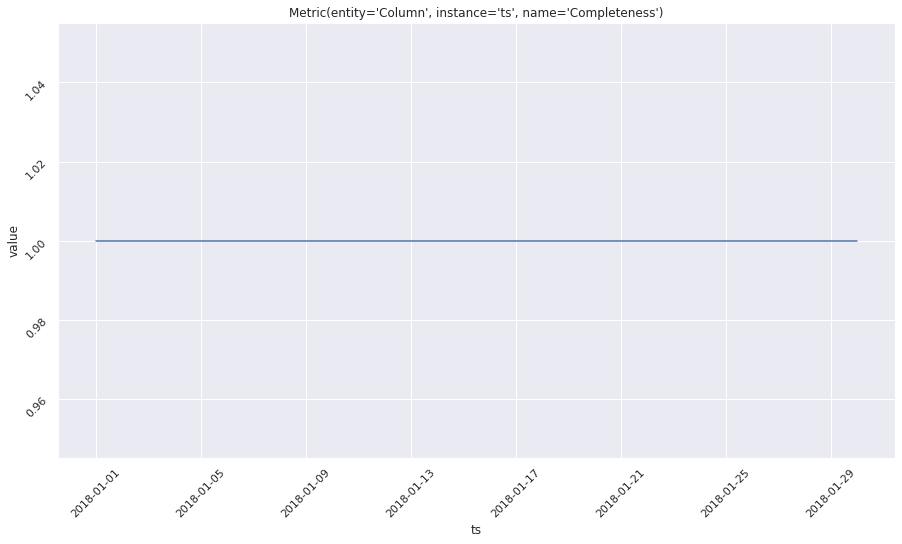

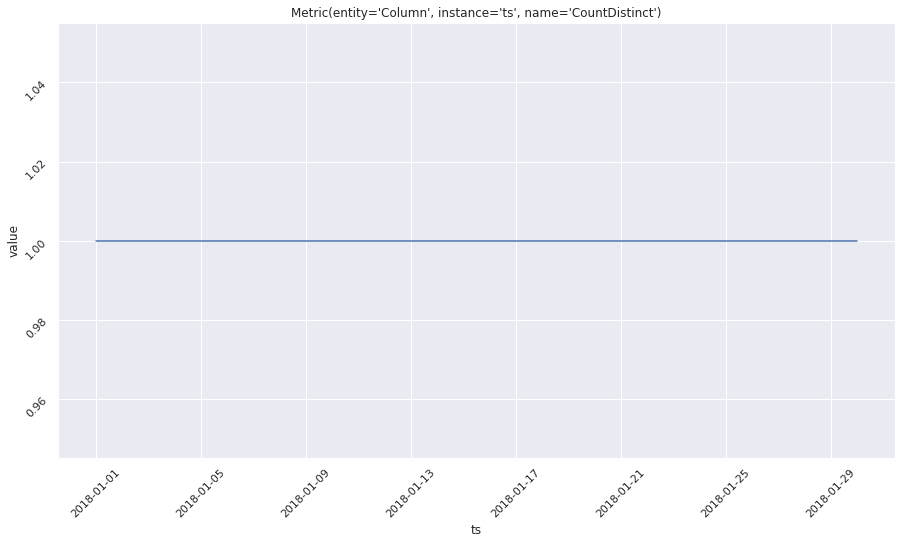

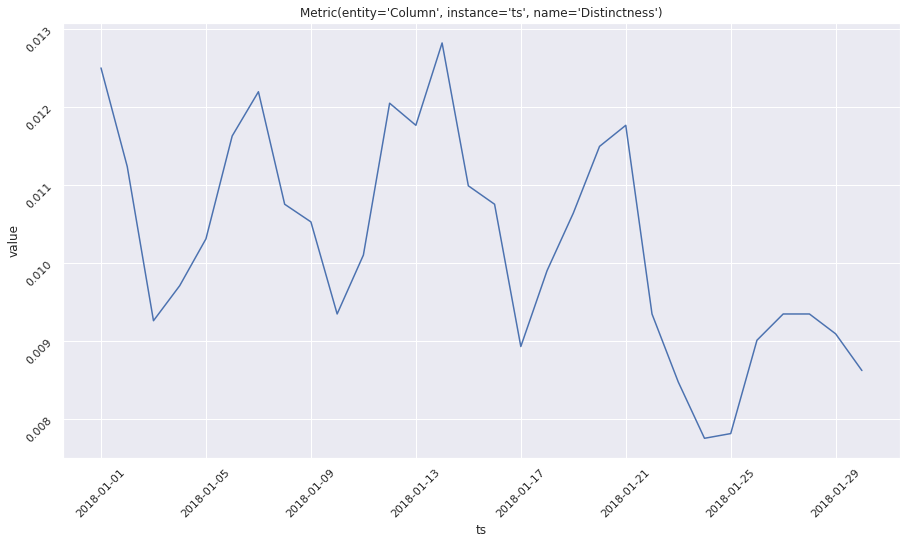

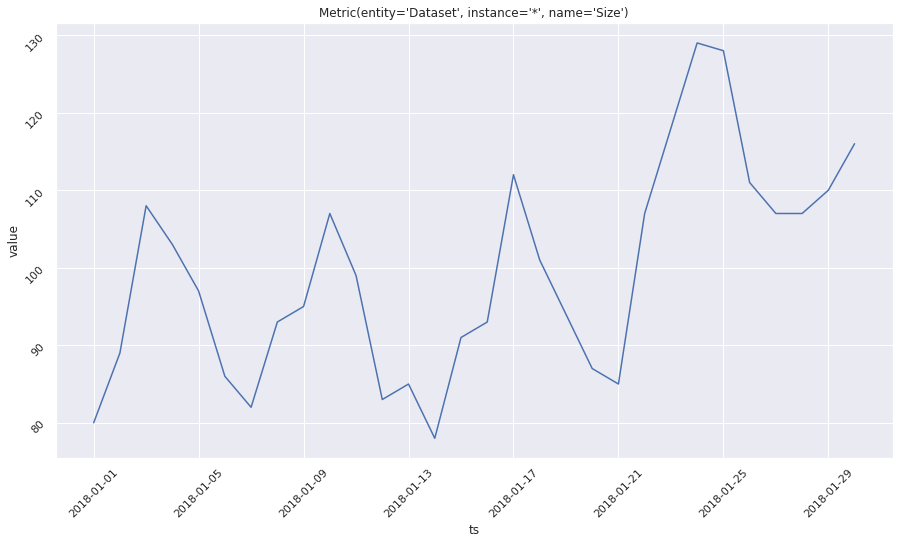

In [17]:
from thoth import viz

for ts in time_series:
    viz.plot_time_series(ts)

# Anomaly Model Optimization

In [18]:
from thoth.anomaly import optimization, models

In [19]:
model_factory = optimization.BaseModelFactory(
    models={
        "Simple": models.SimpleModel,
        "AutoProphet": models.AutoProphetModel,
        "AutoSarima": models.AutoSarimaModel
    }
)

In [20]:
%%time
dataset_optimization_report = optimization.optimize(
    profiling_history=profiling_reports,
    start_proportion=0.5,
    confidence=0.90,
    model_factory=model_factory
)

[2022-05-24 20:28:18,318]::INFO::thoth.anomaly.optimization.optimize: 📈️ Optimization started ...

[2022-05-24 20:28:18,342]::INFO::thoth.anomaly.optimization._optimize_time_series: Optimizing for metric = Metric(entity='Column', instance='category', name='Completeness') started...

[2022-05-24 20:28:19,158]::INFO::thoth.anomaly.optimization._forward_chaining_cross_validation: Cross validation for model Simple started ...

[2022-05-24 20:28:19,159]::INFO::thoth.anomaly.optimization._forward_chaining_cross_validation: Validating 15 timestamps from 2018-01-16T00:00:00 to 2018-01-30T00:00:00.

[2022-05-24 20:28:19,173]::INFO::thoth.anomaly.optimization._validate_last_ts: Finished validation for ts=2018-01-16T00:00:00.

[2022-05-24 20:28:19,180]::INFO::thoth.anomaly.optimization._validate_last_ts: Finished validation for ts=2018-01-17T00:00:00.

[2022-05-24 20:28:19,188]::INFO::thoth.anomaly.optimization._validate_last_ts: Finished validation for ts=2018-01-18T00:00:00.

[2022-05-24 20:28:

### Visualizing models performance in optimization

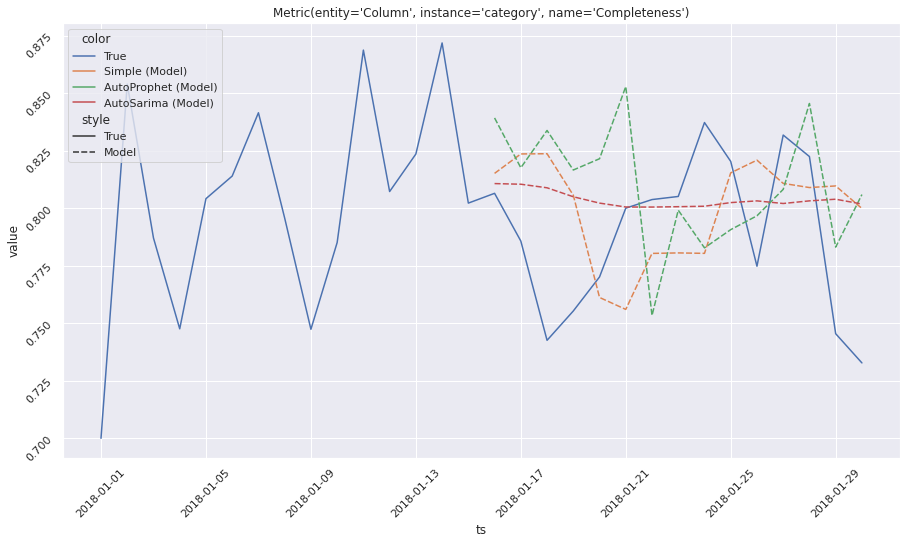

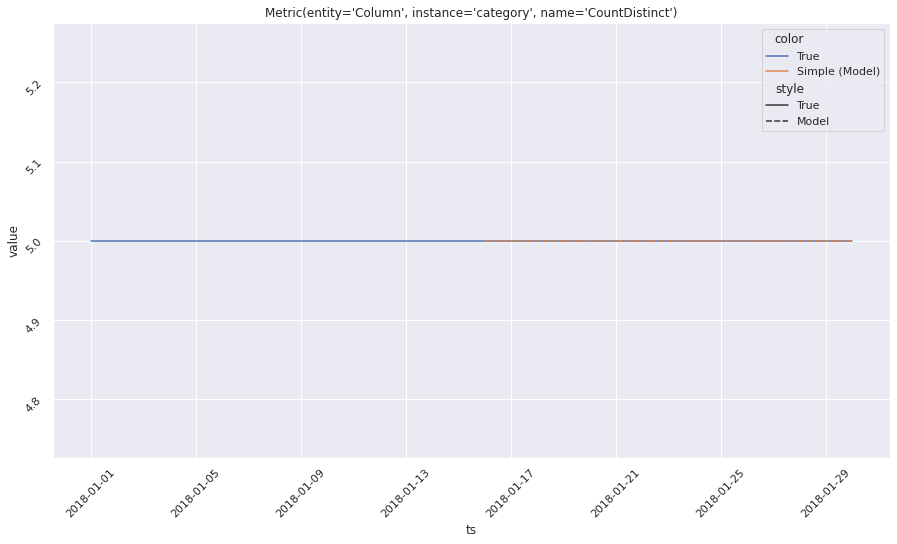

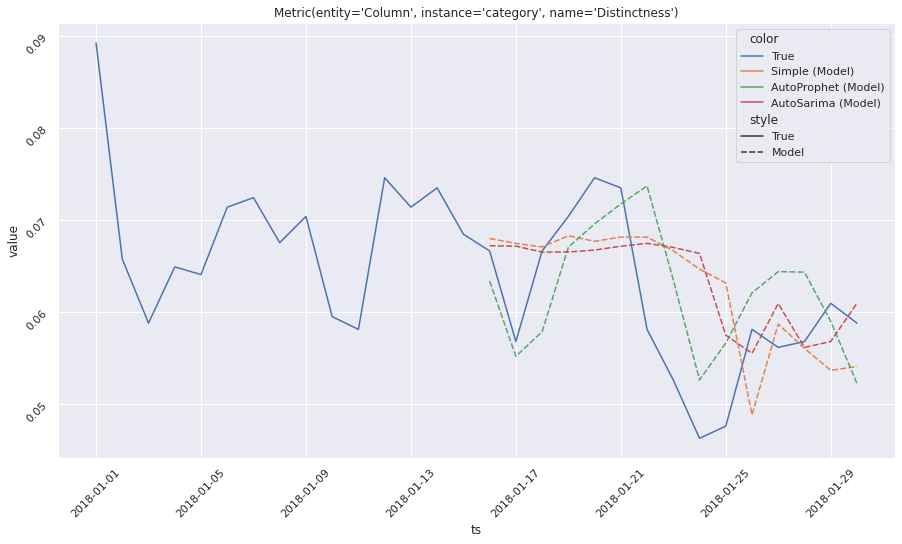

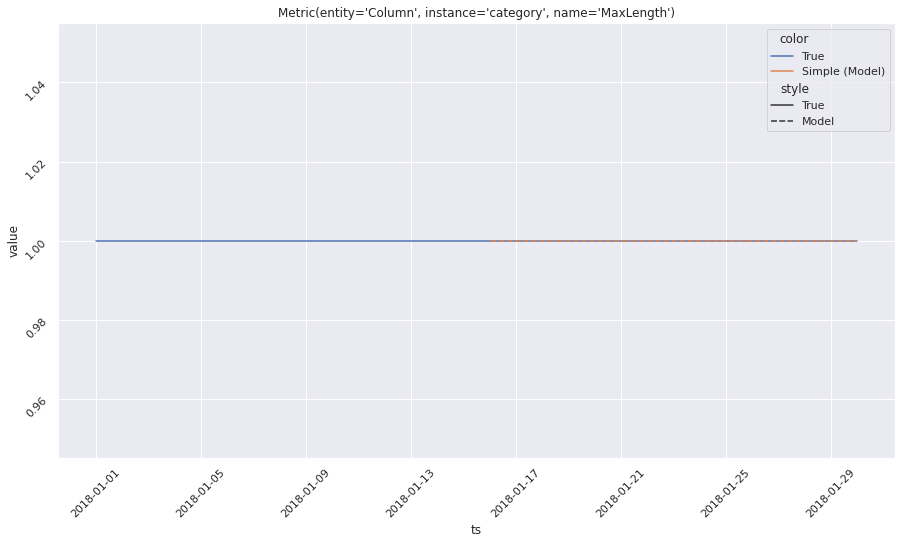

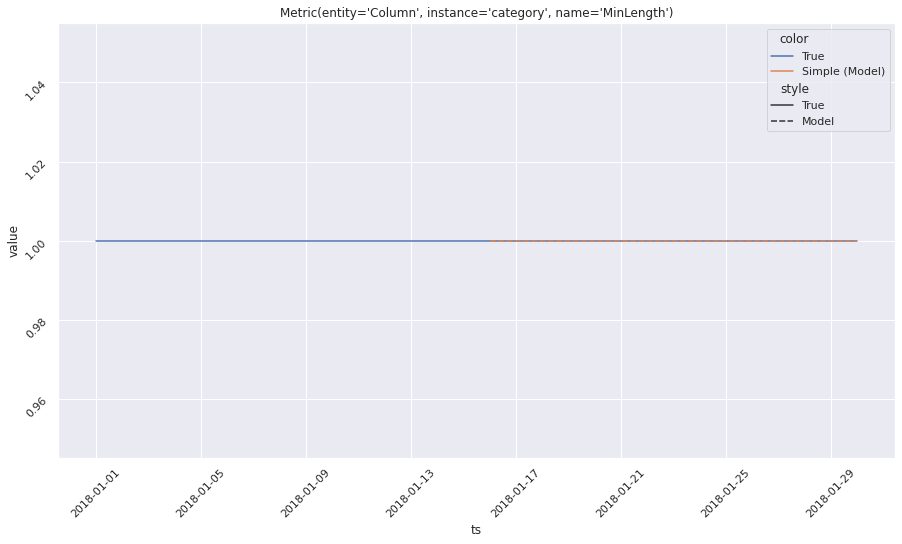

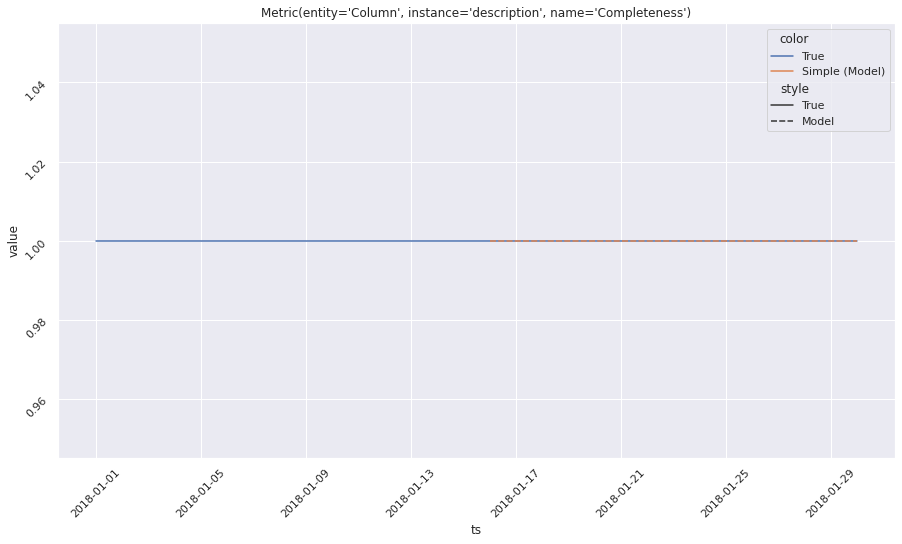

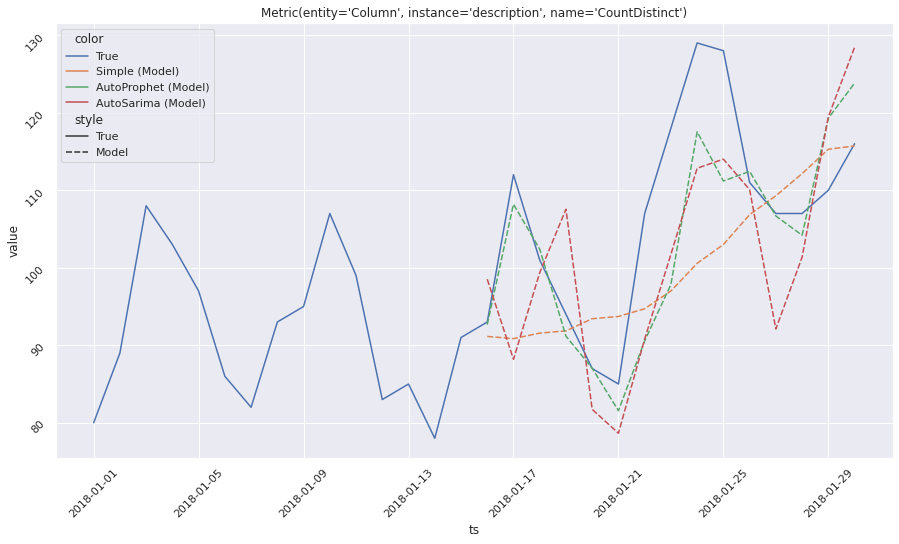

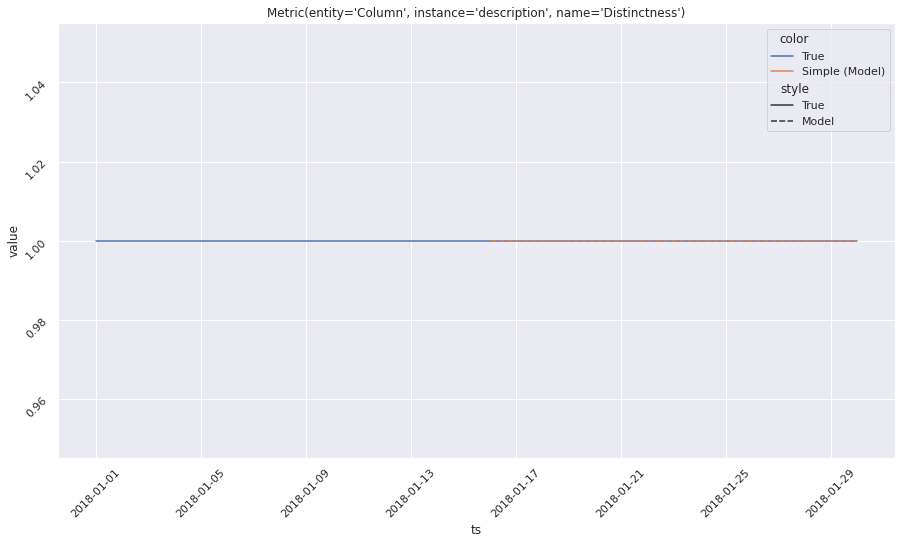

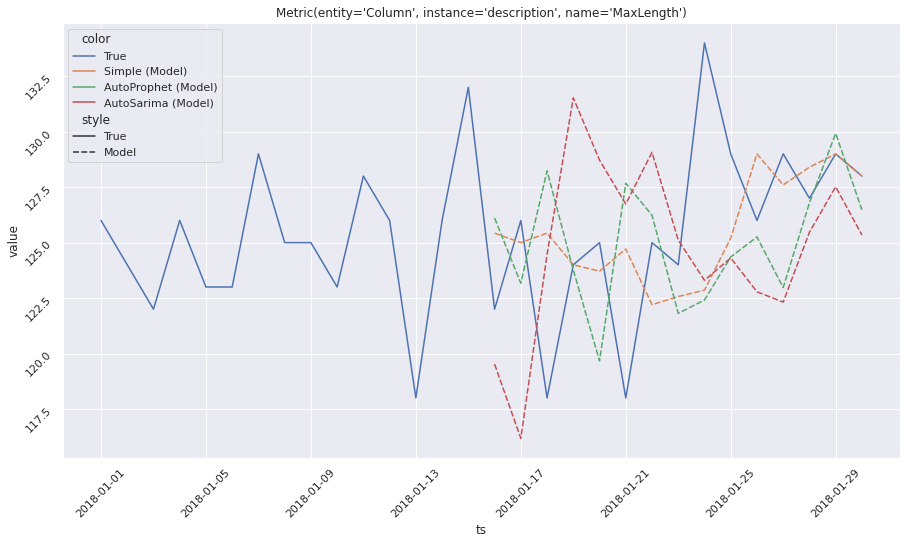

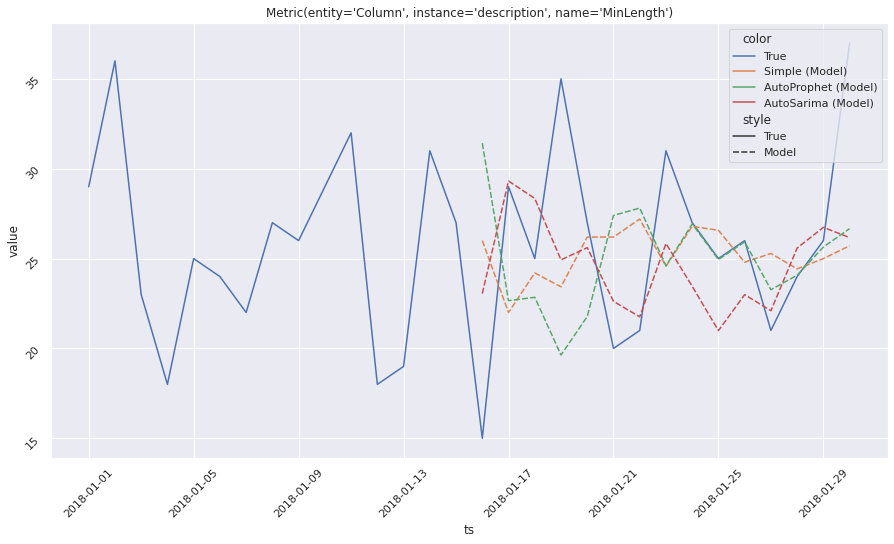

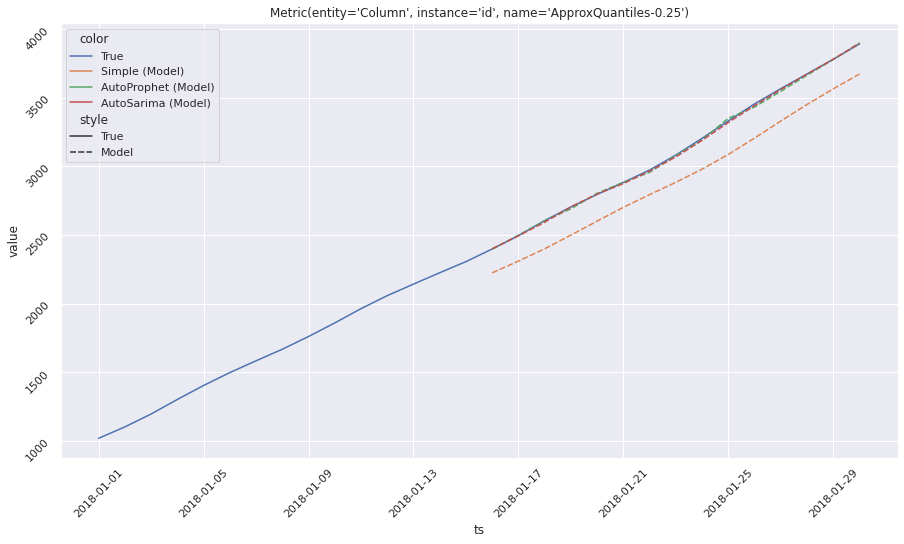

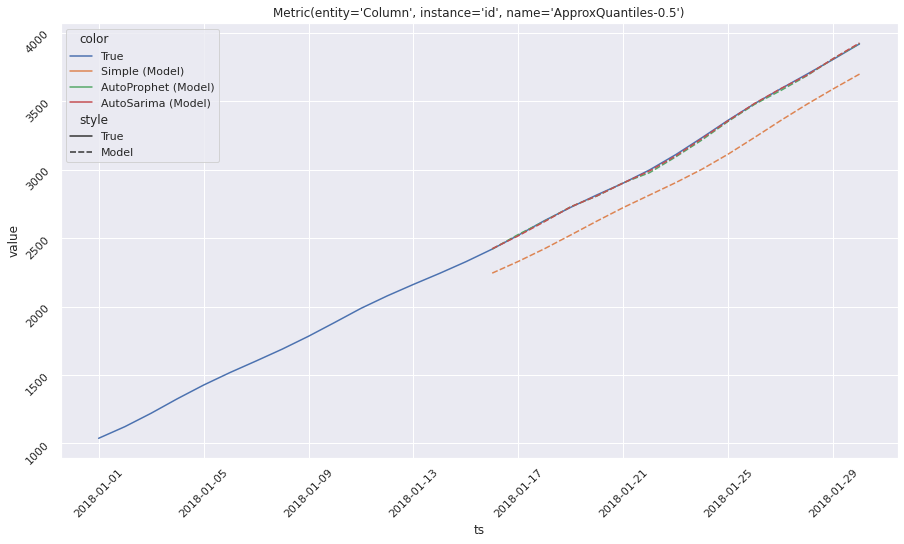

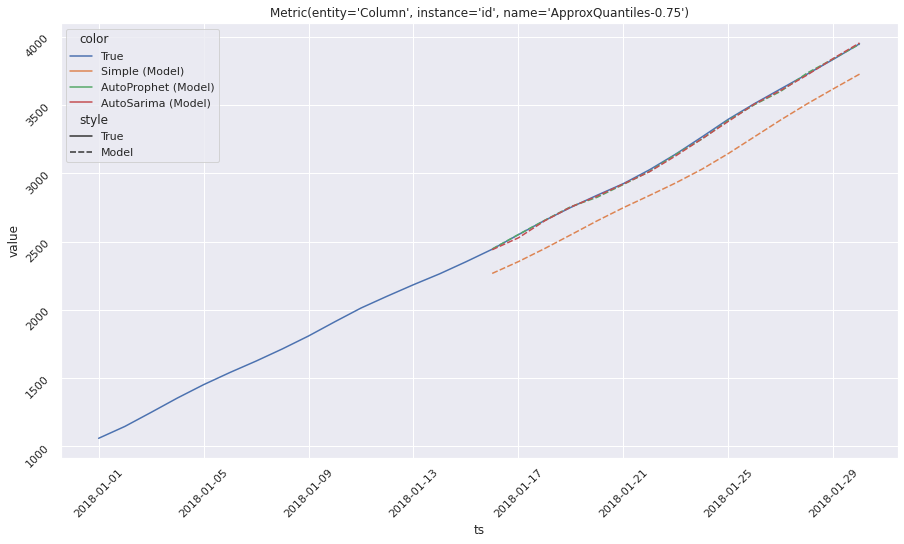

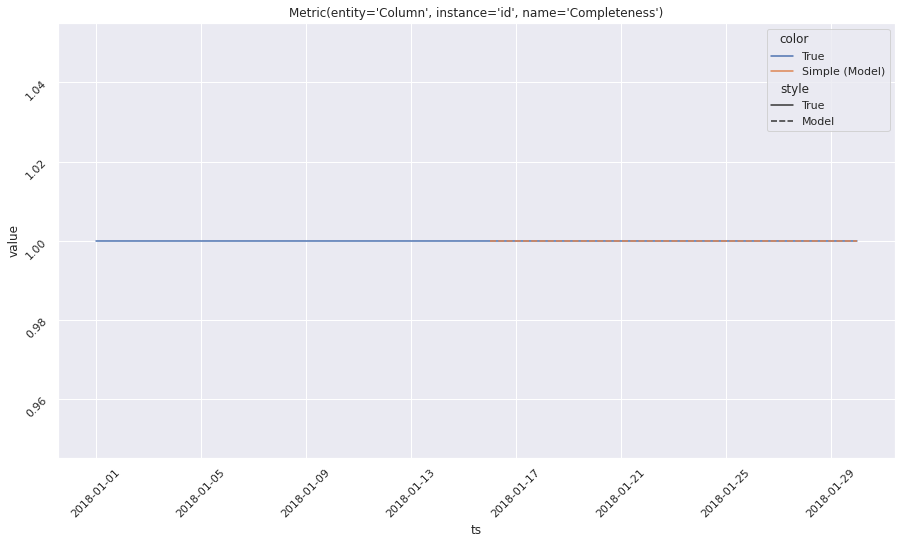

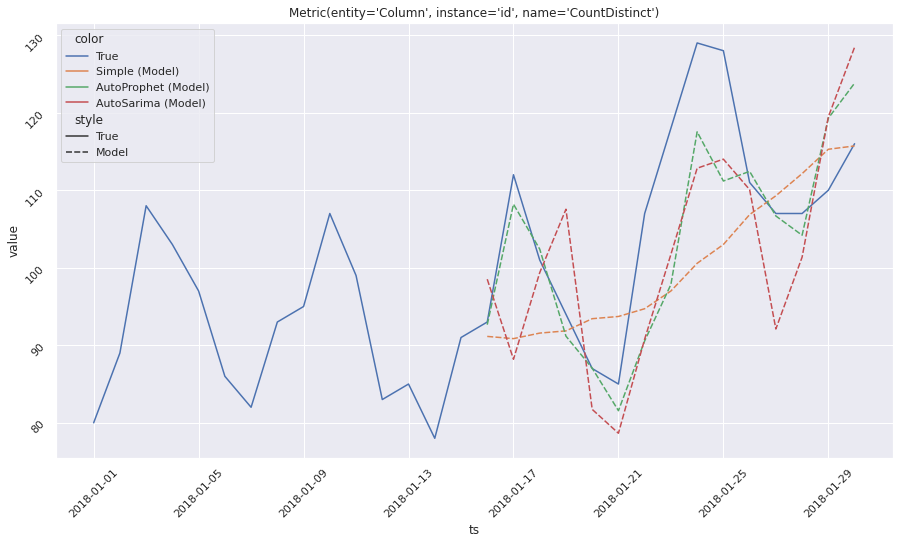

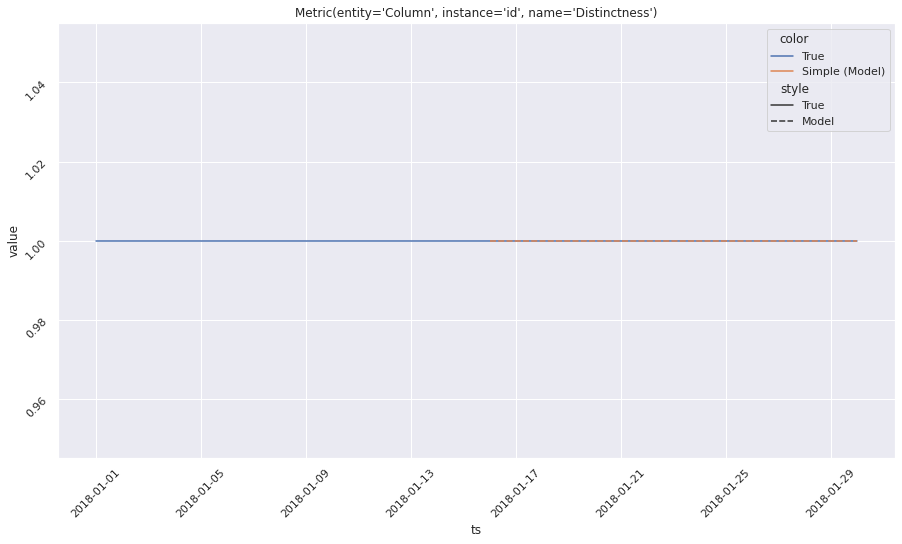

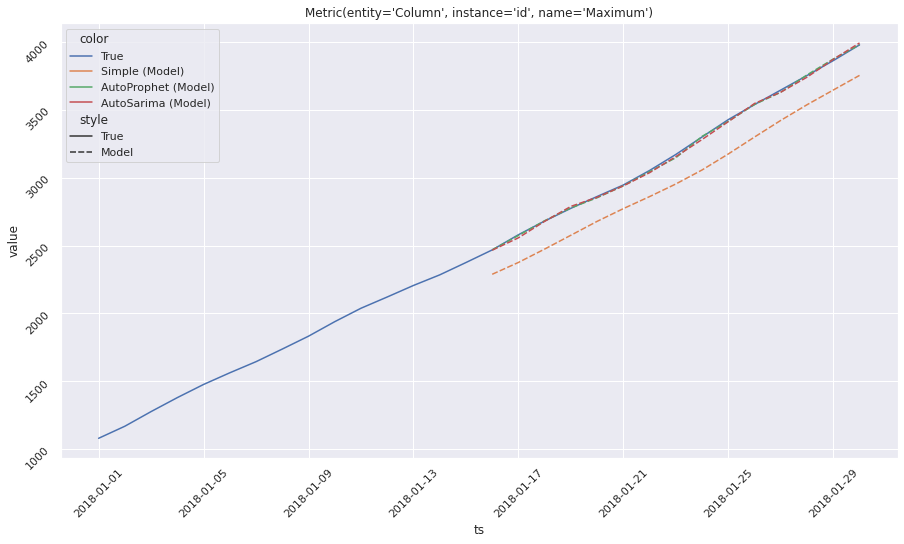

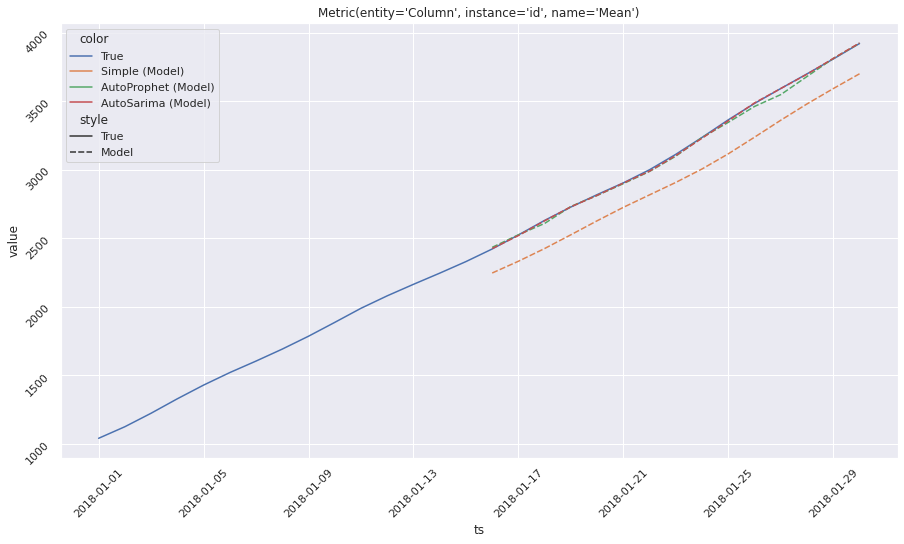

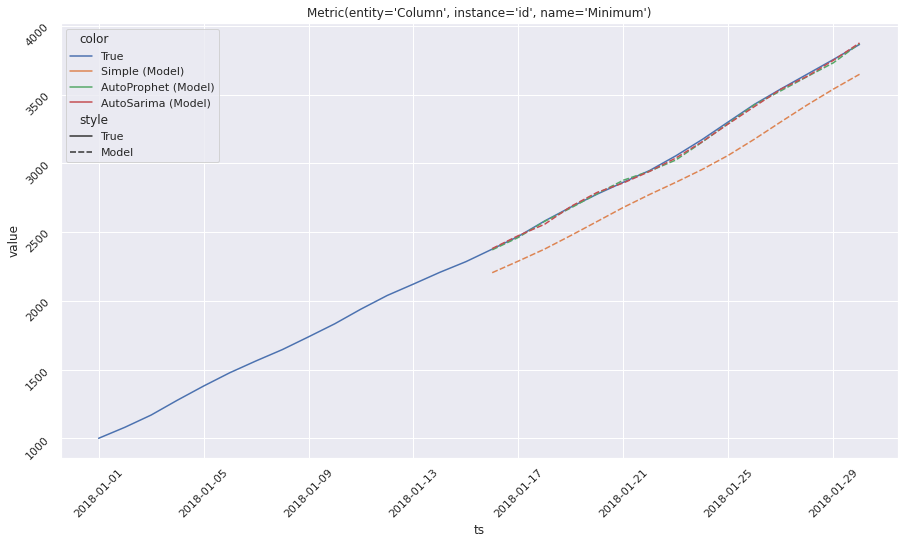

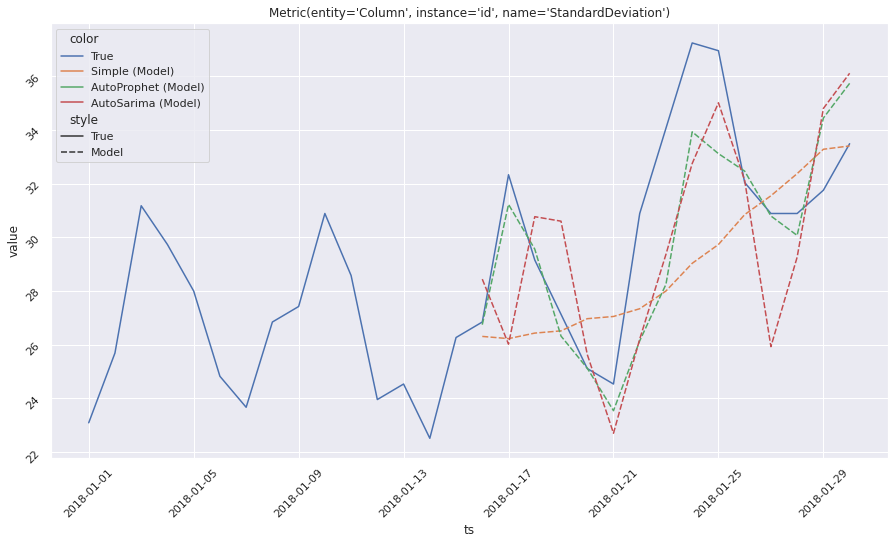

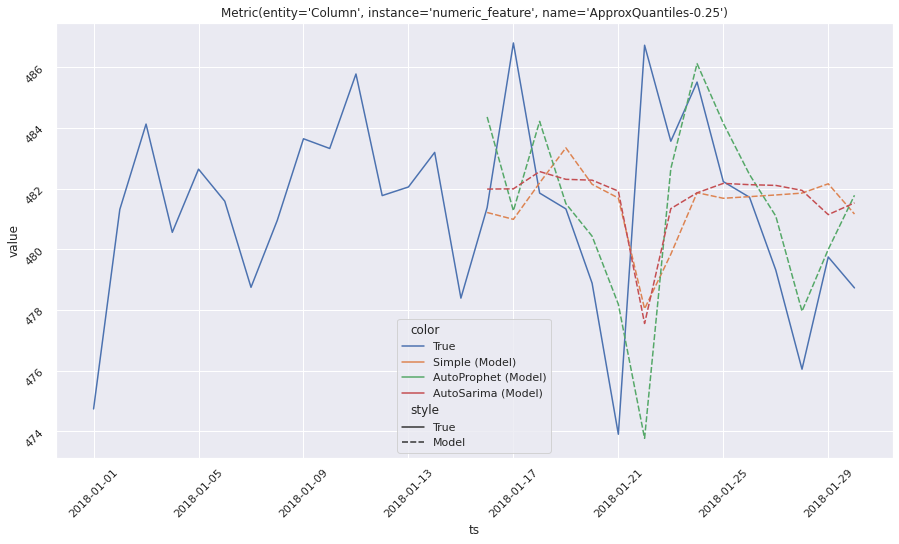

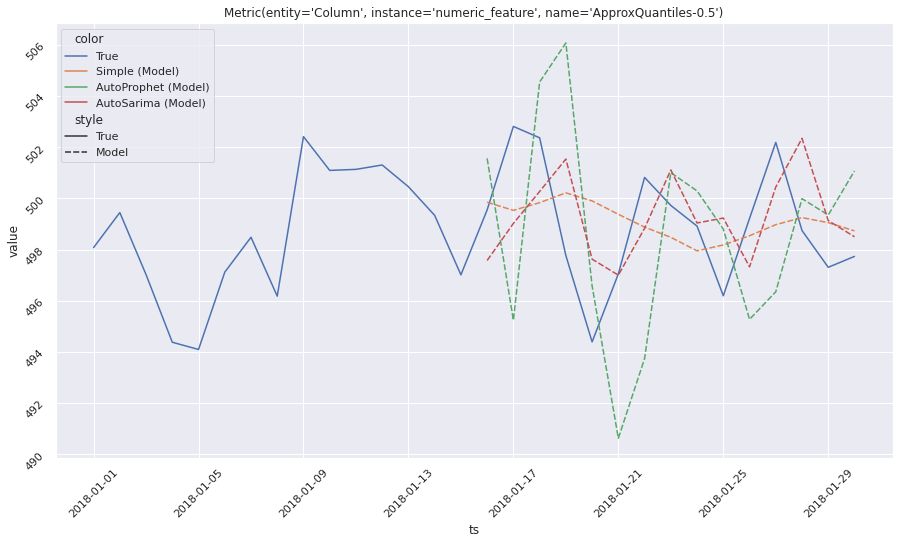

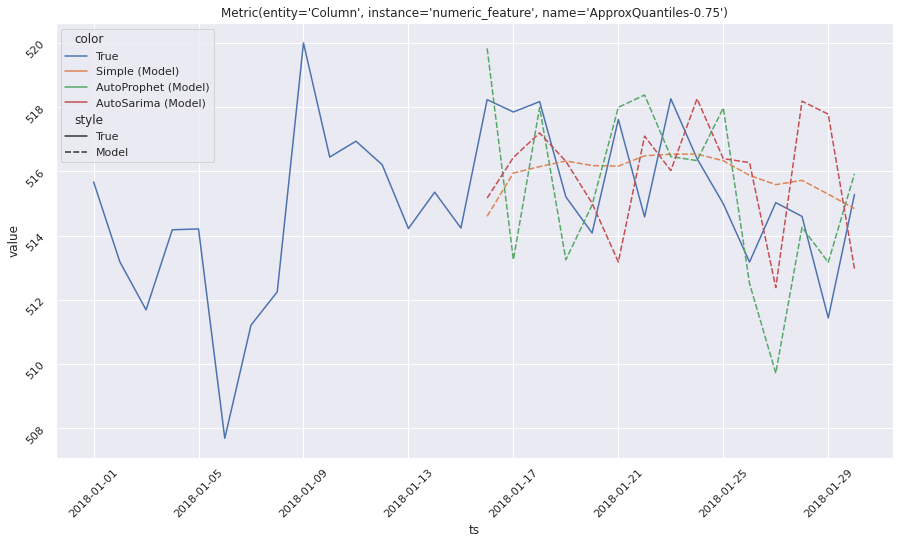

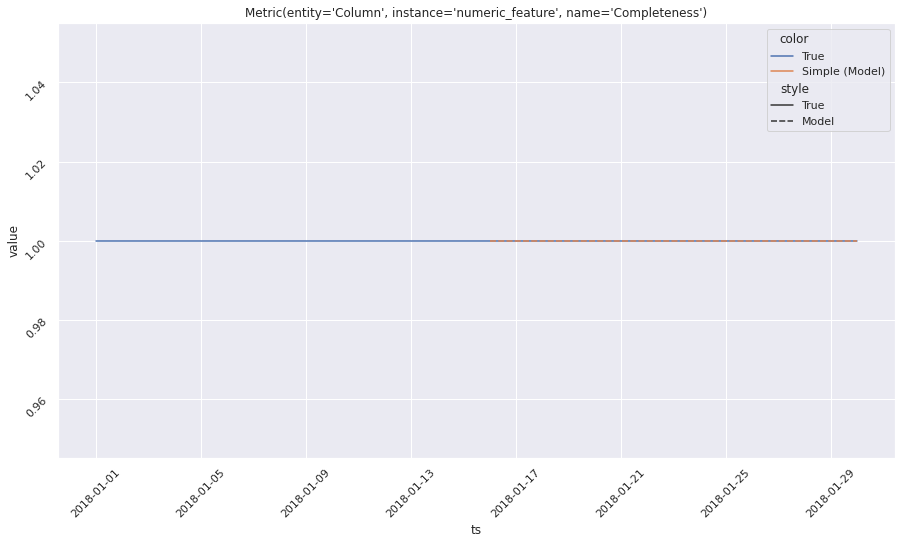

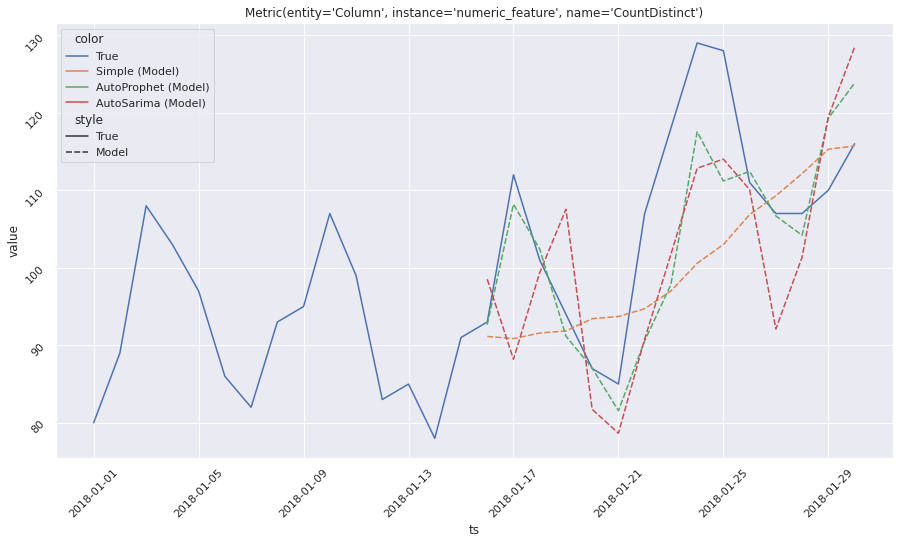

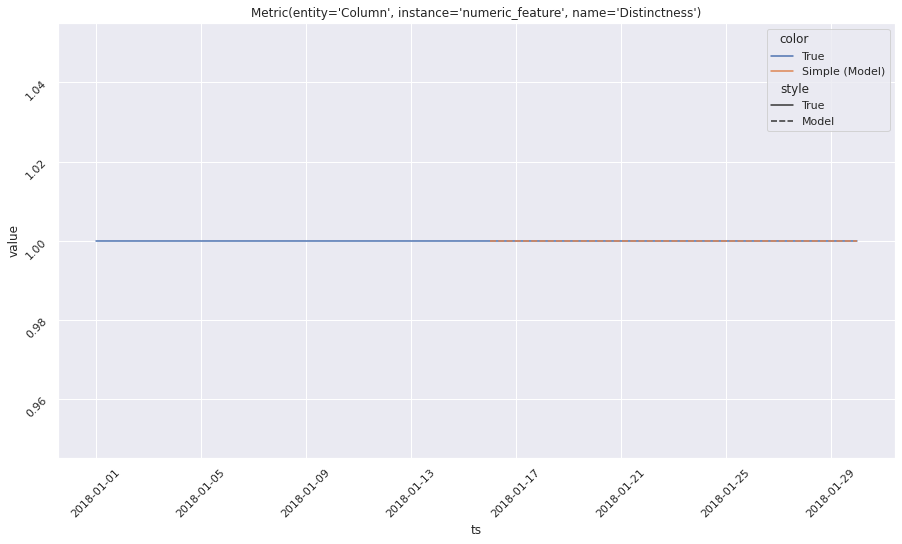

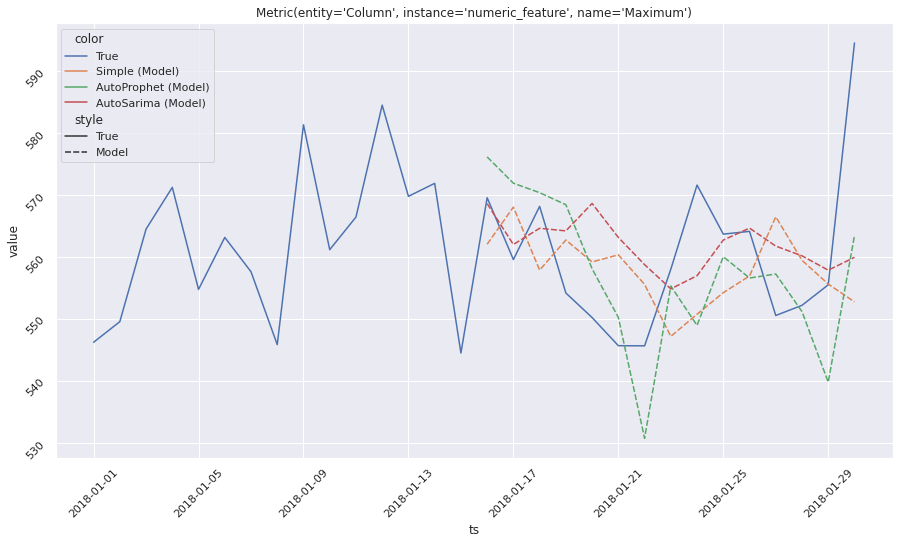

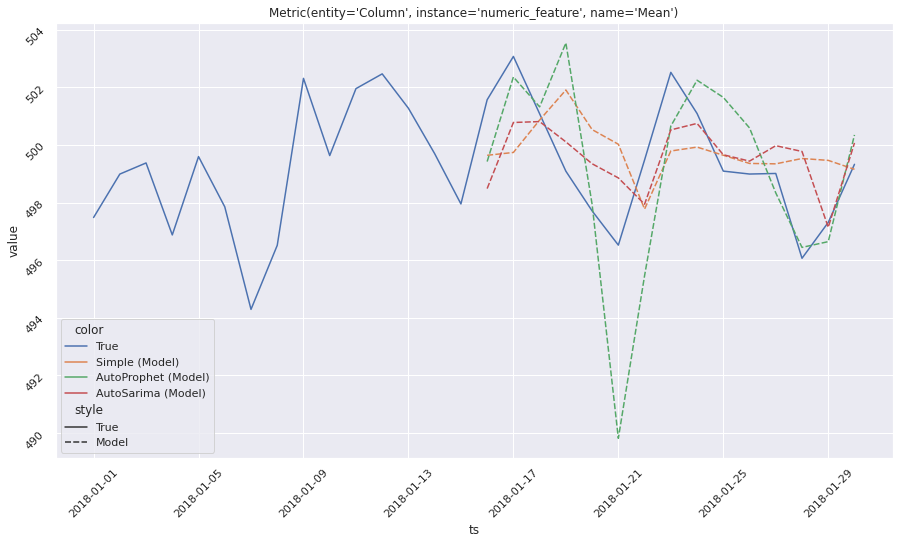

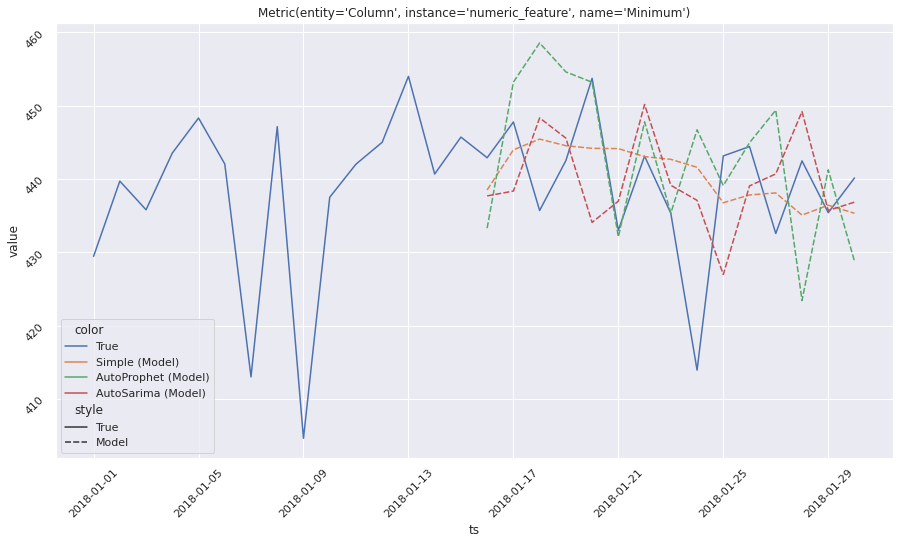

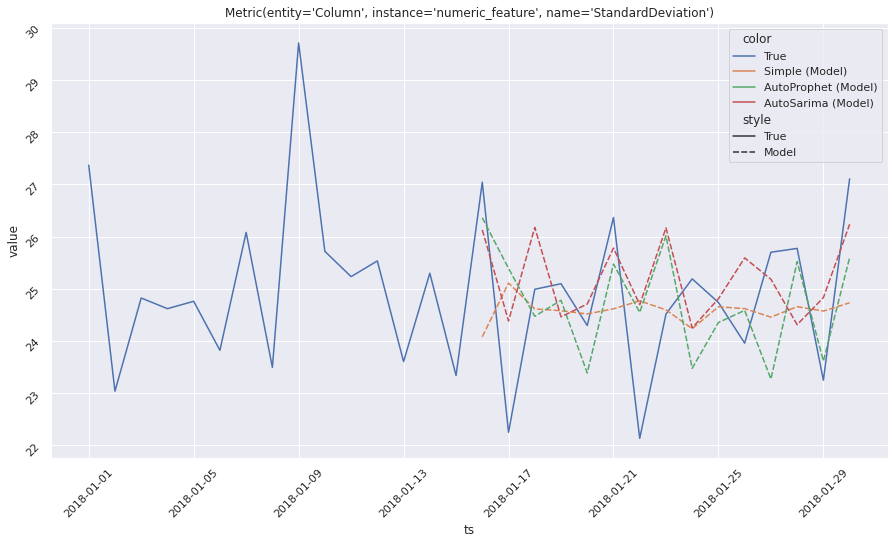

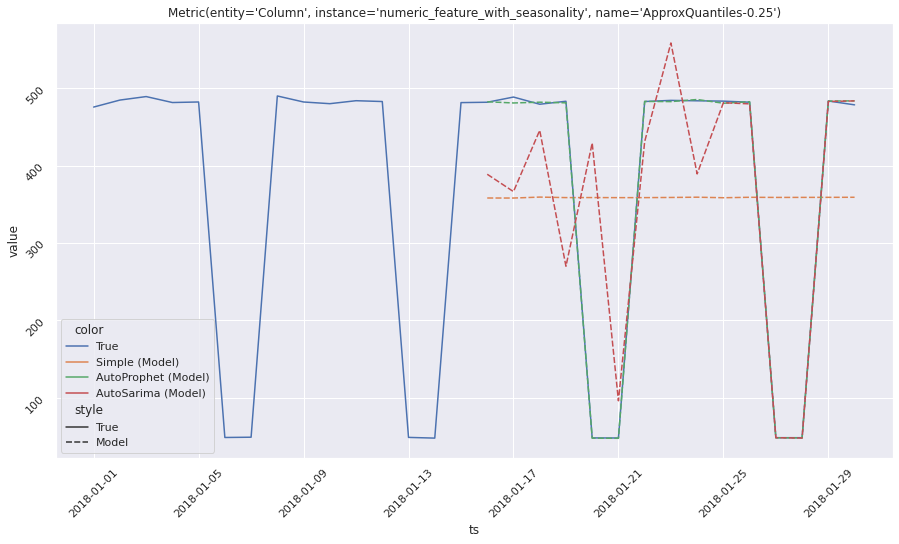

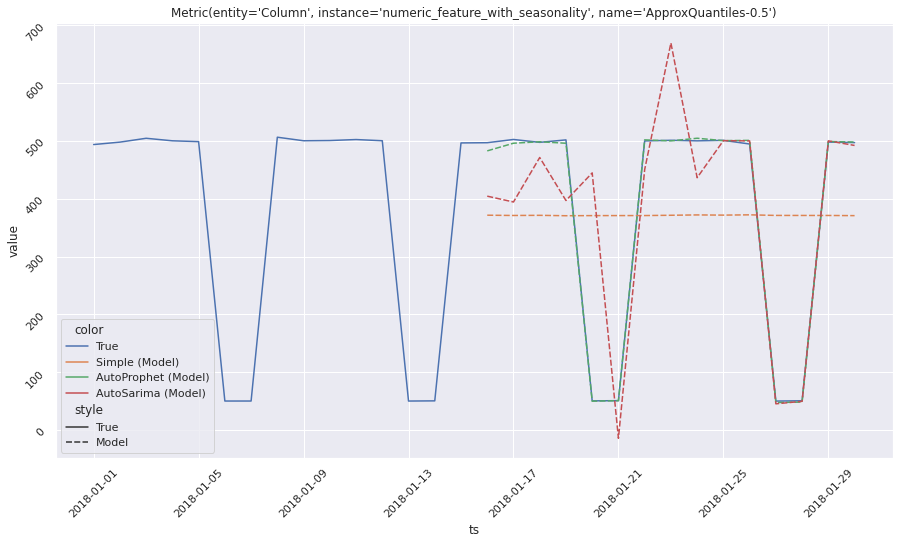

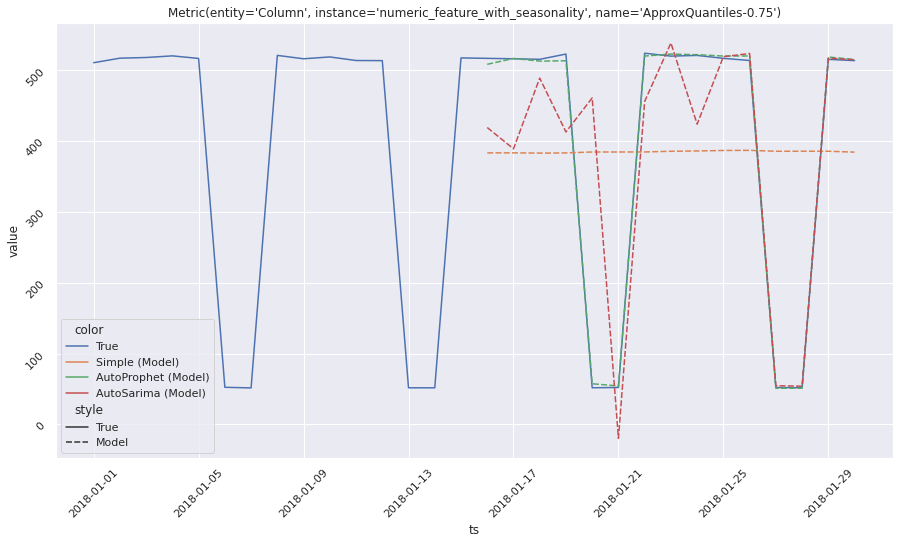

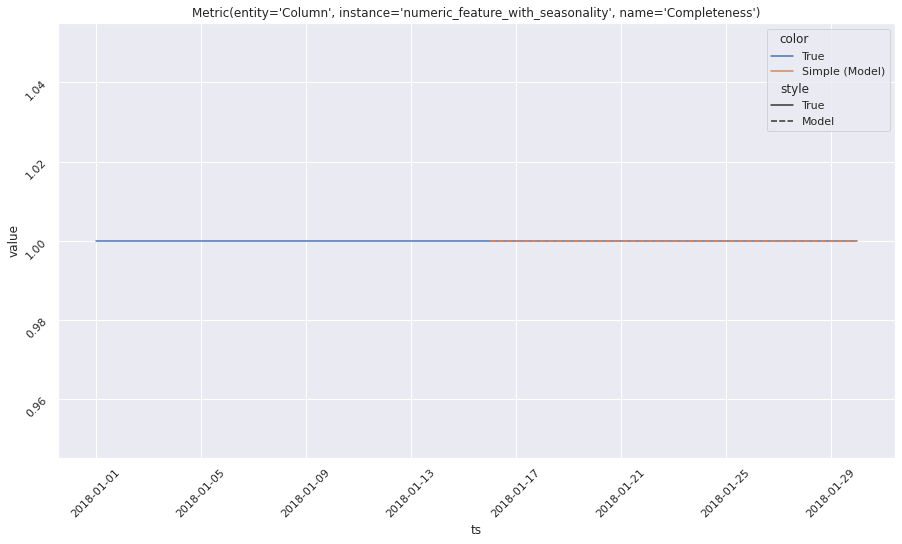

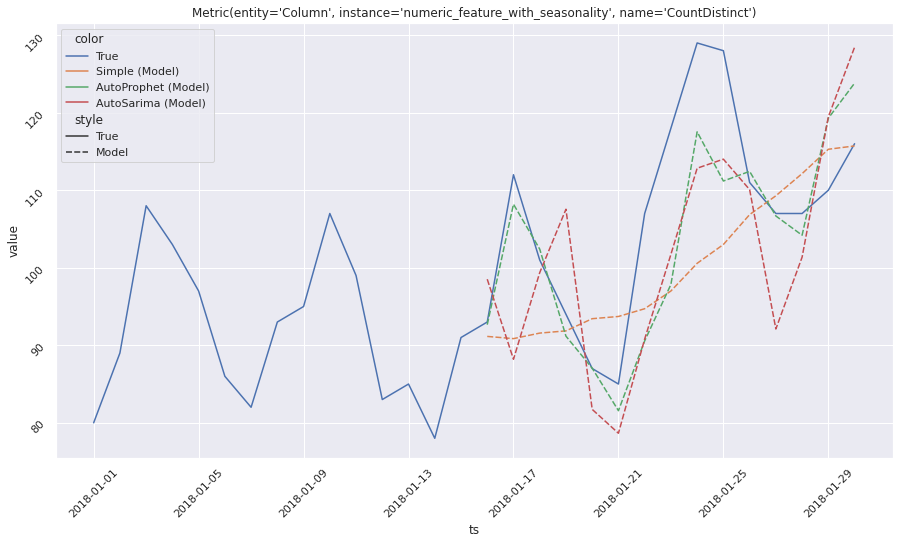

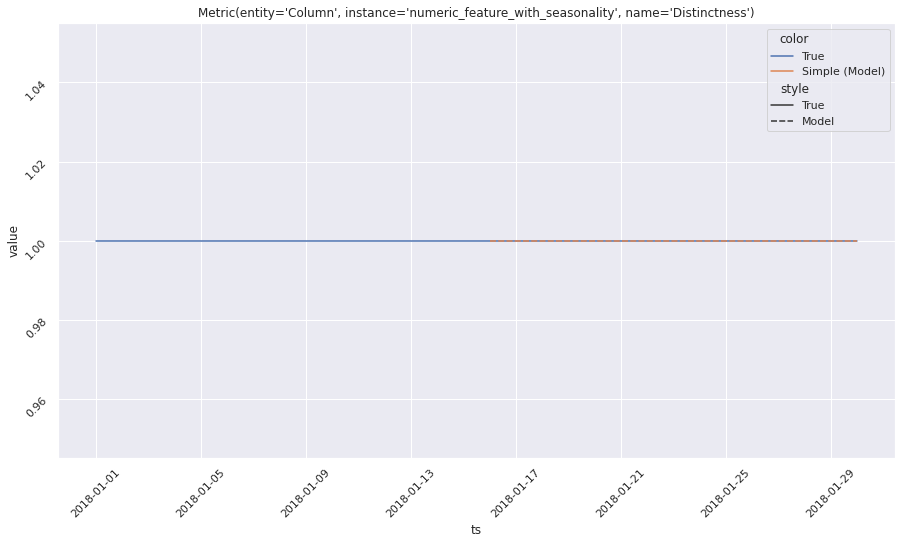

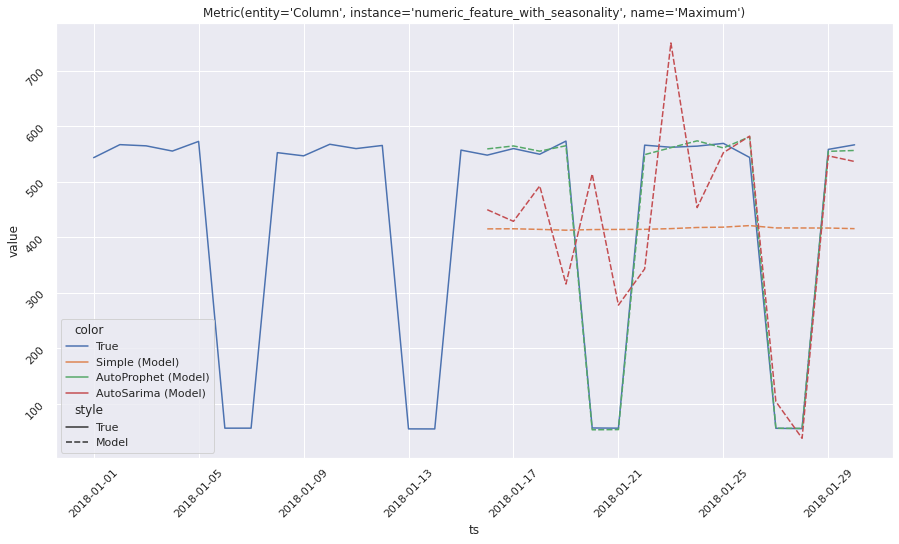

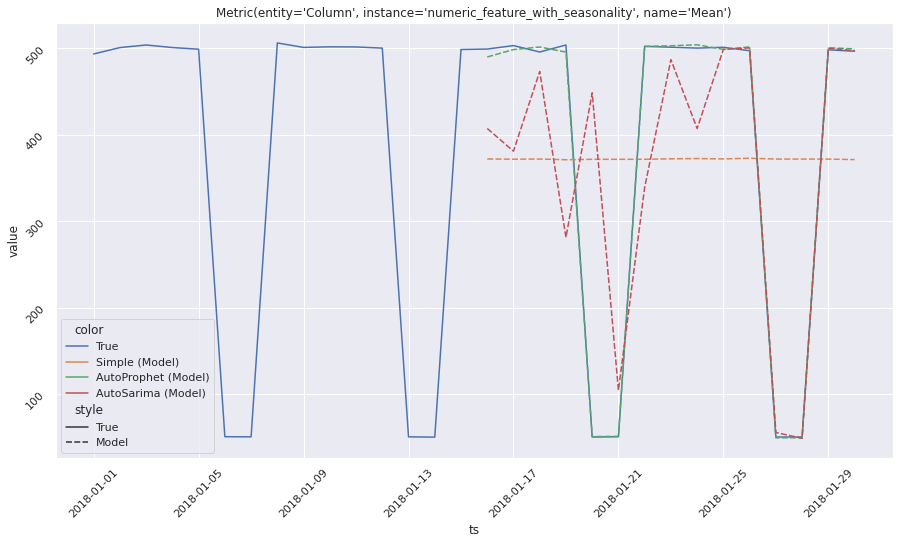

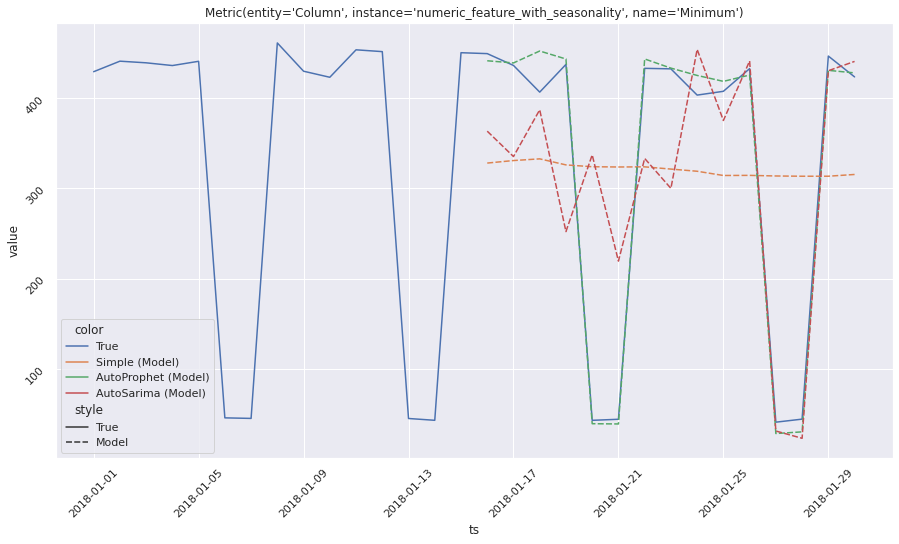

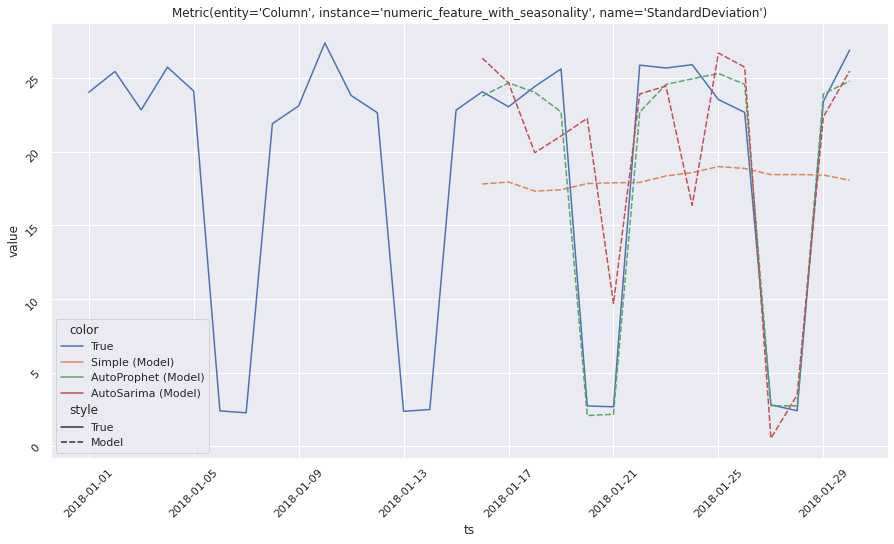

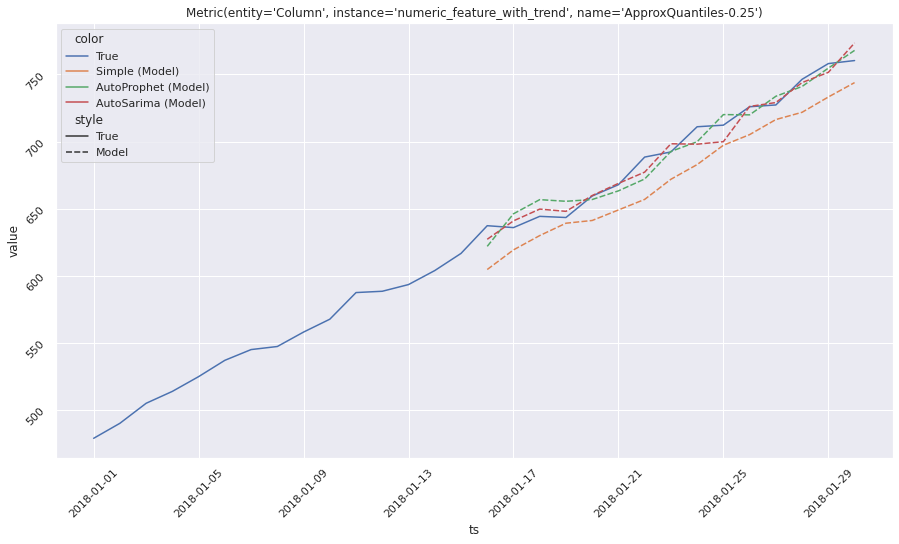

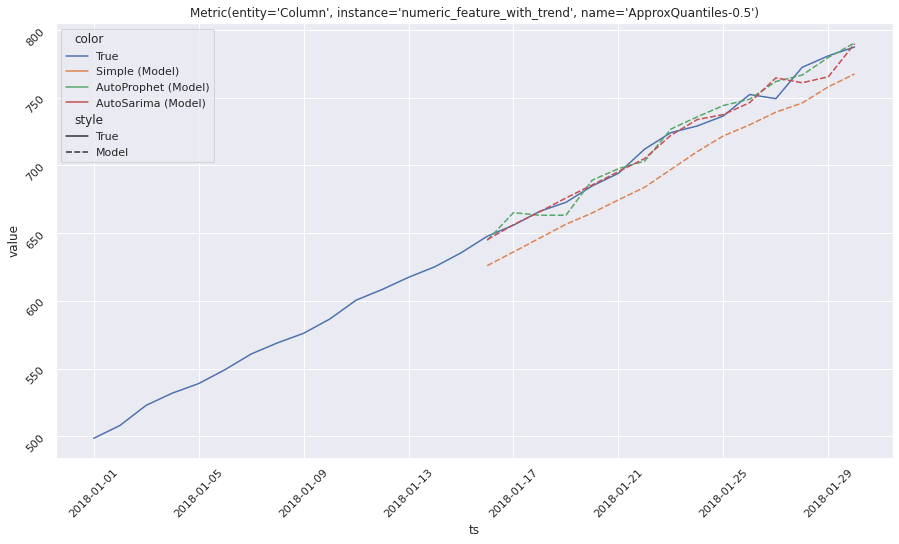

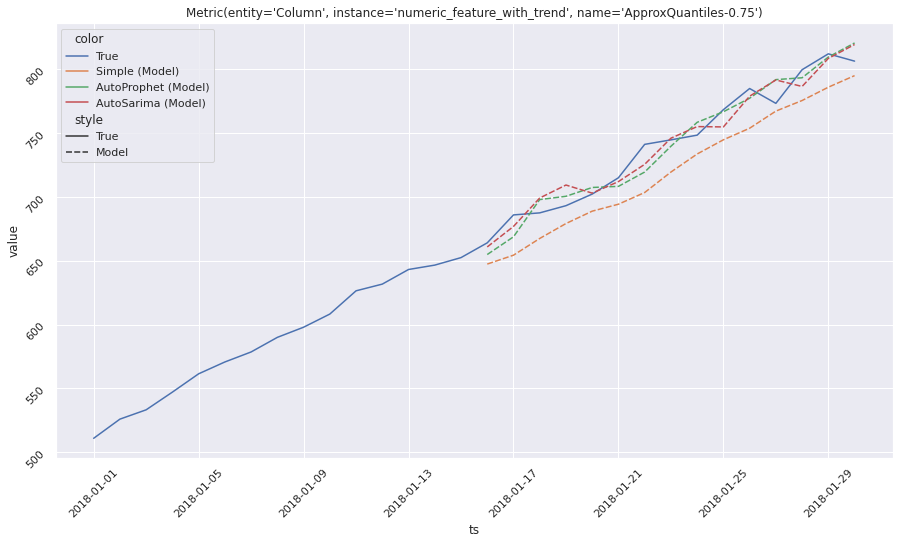

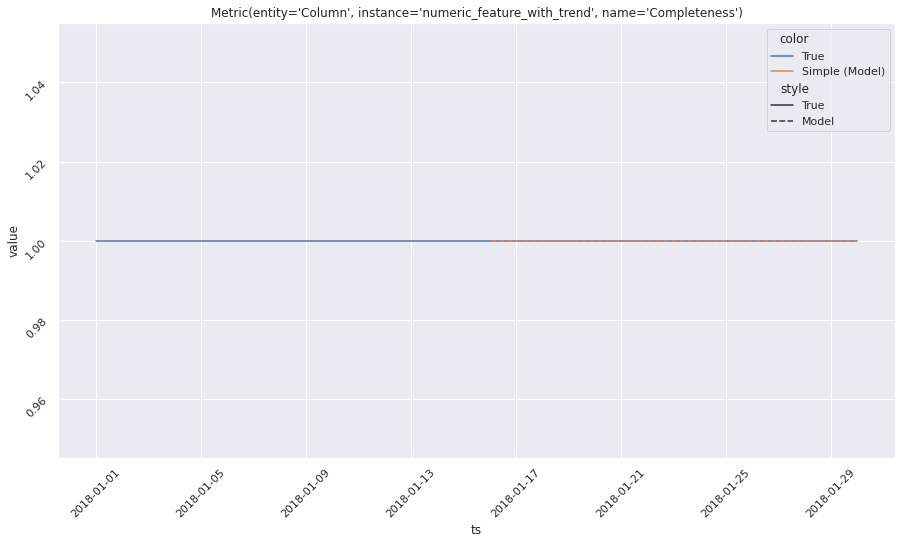

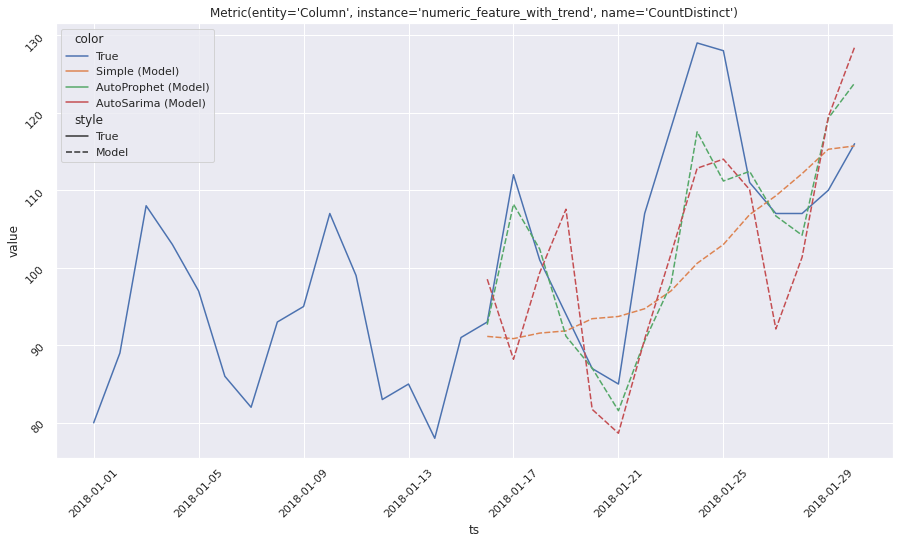

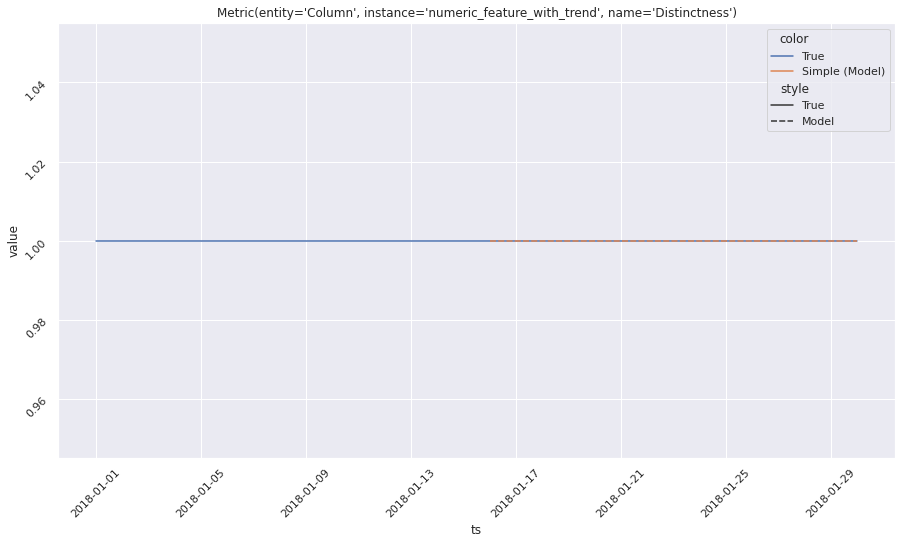

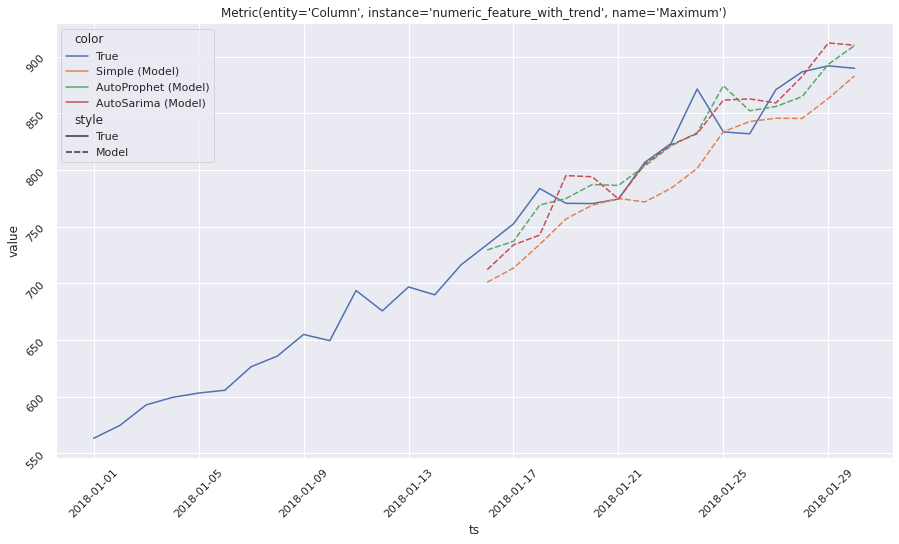

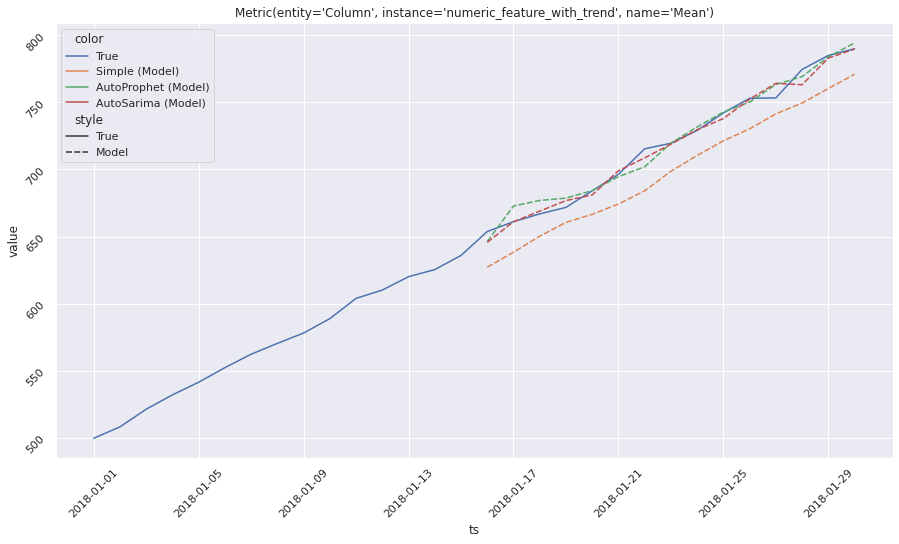

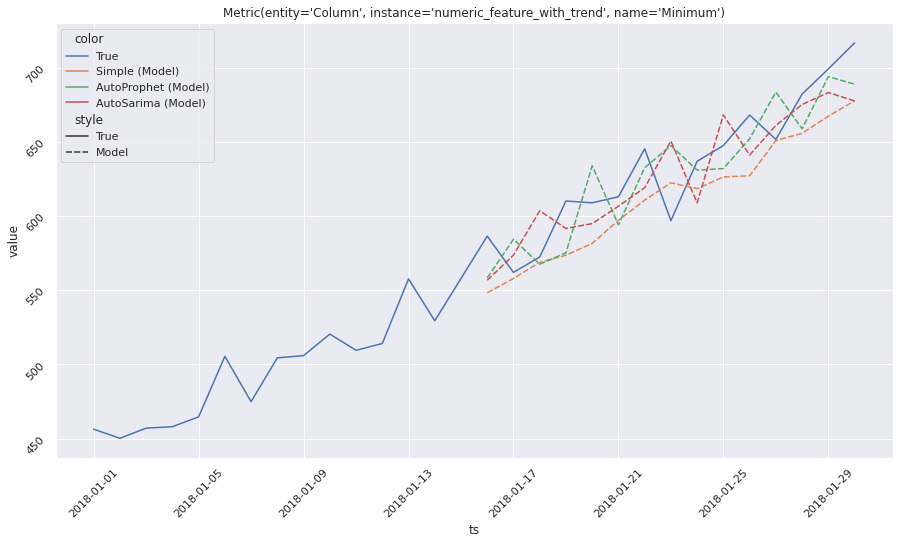

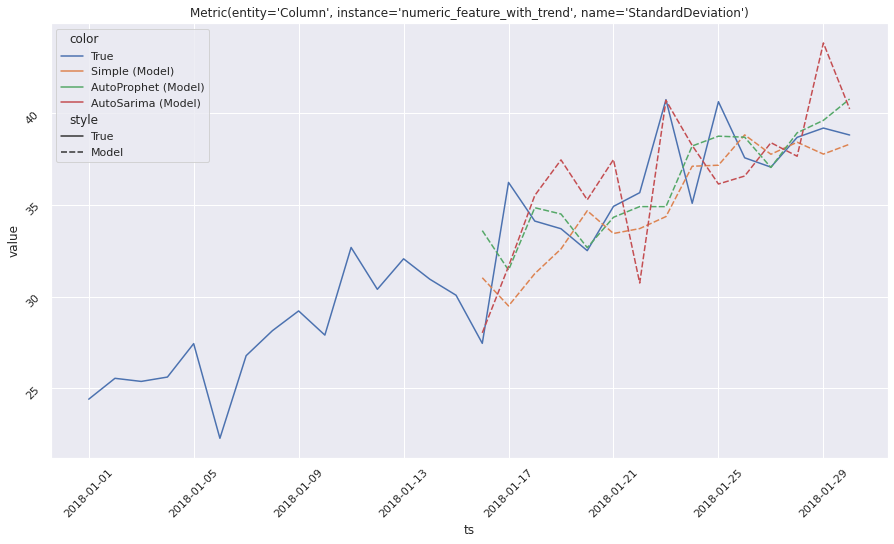

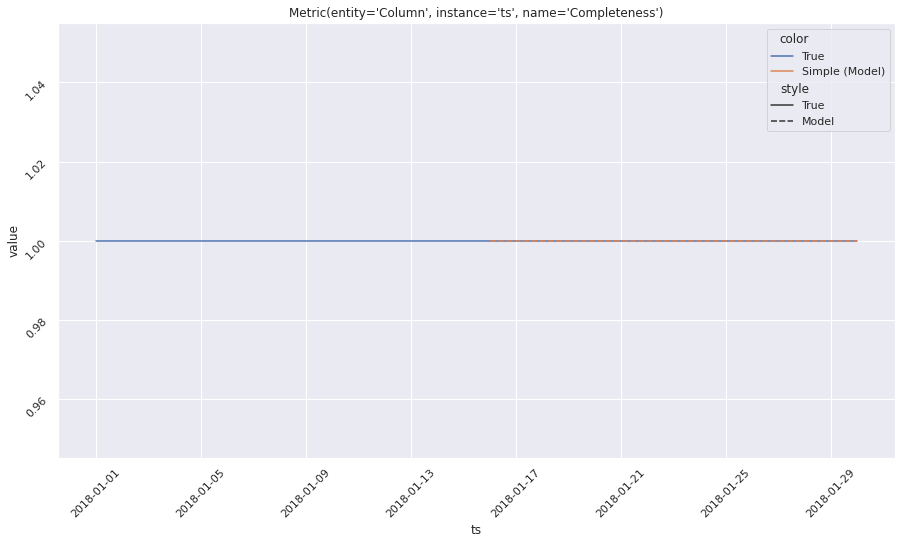

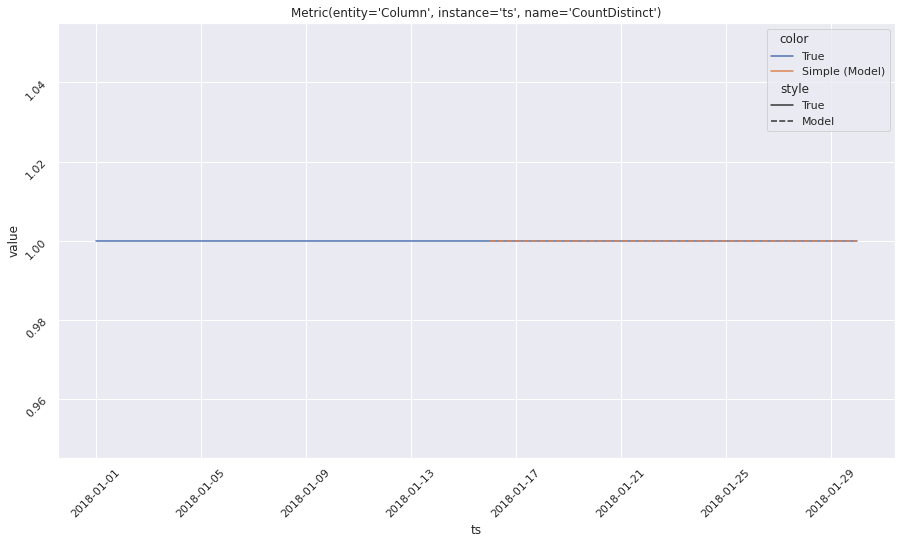

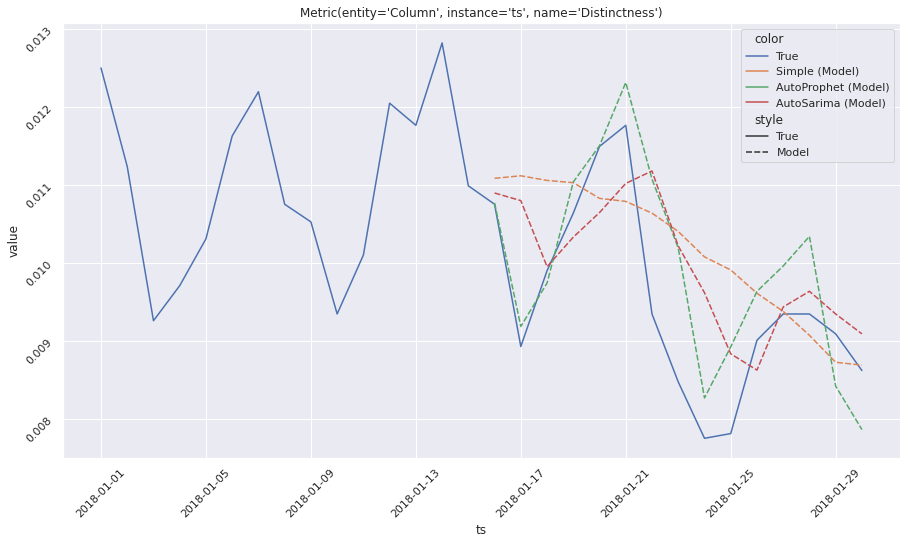

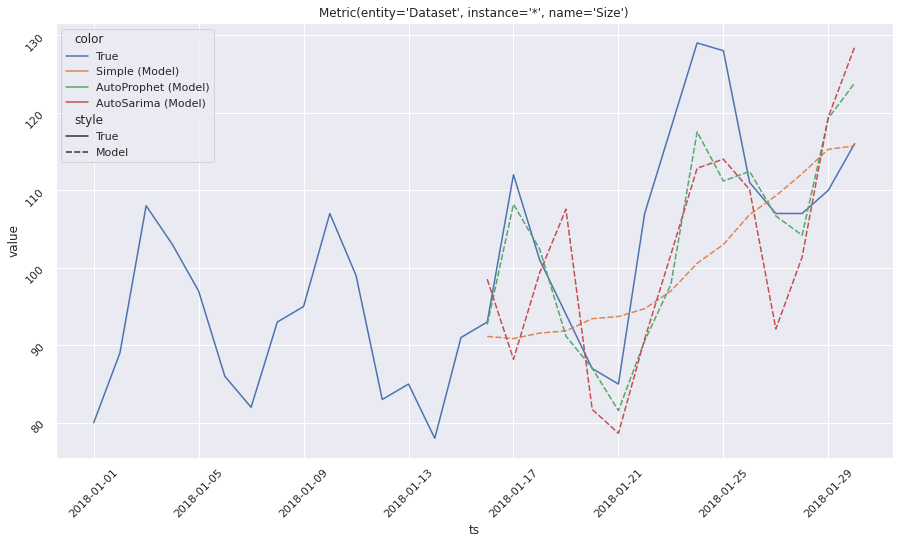

In [21]:
# Metrics time series compared to model results in cross validation
for metric_report in dataset_optimization_report.metric_anomaly_optimization_reports:
    viz.plot_validation_time_series(metric_report.validation_results, metric_report.metric)

In [22]:
# Summary table for models results
viz.tabulate_optimization_report_scores(dataset_optimization_report)

metric  \
0     Metric(entity='Column', instance='category', name='Completeness')   
1     Metric(entity='Column', instance='category', name='Completeness')   
2     Metric(entity='Column', instance='category', name='Completeness')   
3    Metric(entity='Column', instance='category', name='CountDistinct')   
4     Metric(entity='Column', instance='category', name='Distinctness')   
..                                                                  ...   
127         Metric(entity='Column', instance='ts', name='Distinctness')   
128         Metric(entity='Column', instance='ts', name='Distinctness')   
129                 Metric(entity='Dataset', instance='*', name='Size')   
130                 Metric(entity='Dataset', instance='*', name='Size')   
131                 Metric(entity='Dataset', instance='*', name='Size')   

           model  mean_error  threshold  below_threshold_proportion  
0         Simple    0.047581       0.10                    0.933333  
1    AutoProphet    0.054939       0.10                    0.933333  
2     AutoSarima    0.038480       0.09                    0.933333  
3         Simple    0.000000       0.01                    1.000000  
4         Simple    0.132787       0.33                    0.933333  
..           ...         ...        ...                         ...  
127  AutoProphet    0.075422       0.19                    0.933333  
128   AutoSarima    0.088892       0.21                    0.933333  
129       Simple    0.091136       0.20                    0.933333  
130  AutoProphet    0.057401       0.16                    0.933333  
131   AutoSarima    0.098991       0.16                    0.933333  

[132 rows x 5 columns]

In [23]:
# Showing best model and threshold chosen for each metric
viz.tabulate_optimization_report_best_model(dataset_optimization_report)

metric  \
0                                   Metric(entity='Column', instance='category', name='Completeness')   
1                                  Metric(entity='Column', instance='category', name='CountDistinct')   
2                                   Metric(entity='Column', instance='category', name='Distinctness')   
3                                      Metric(entity='Column', instance='category', name='MaxLength')   
4                                      Metric(entity='Column', instance='category', name='MinLength')   
5                                Metric(entity='Column', instance='description', name='Completeness')   
6                               Metric(entity='Column', instance='description', name='CountDistinct')   
7                                Metric(entity='Column', instance='description', name='Distinctness')   
8                                   Metric(entity='Column', instance='description', name='MaxLength')   
9                                   Metric(entity='Column', instance='description', name='MinLength')   
10                                Metric(entity='Column', instance='id', name='ApproxQuantiles-0.25')   
11                                 Metric(entity='Column', instance='id', name='ApproxQuantiles-0.5')   
12                                Metric(entity='Column', instance='id', name='ApproxQuantiles-0.75')   
13                                        Metric(entity='Column', instance='id', name='Completeness')   
14                                       Metric(entity='Column', instance='id', name='CountDistinct')   
15                                        Metric(entity='Column', instance='id', name='Distinctness')   
16                                             Metric(entity='Column', instance='id', name='Maximum')   
17                                                Metric(entity='Column', instance='id', name='Mean')   
18                                             Metric(entity='Column', instance='id', name='Minimum')   
19                                   Metric(entity='Column', instance='id', name='StandardDeviation')   
20                   Metric(entity='Column', instance='numeric_feature', name='ApproxQuantiles-0.25')   
21                    Metric(entity='Column', instance='numeric_feature', name='ApproxQuantiles-0.5')   
22                   Metric(entity='Column', instance='numeric_feature', name='ApproxQuantiles-0.75')   
23                           Metric(entity='Column', instance='numeric_feature', name='Completeness')   
24                          Metric(entity='Column', instance='numeric_feature', name='CountDistinct')   
25                           Metric(entity='Column', instance='numeric_feature', name='Distinctness')   
26                                Metric(entity='Column', instance='numeric_feature', name='Maximum')   
27                                   Metric(entity='Column', instance='numeric_feature', name='Mean')   
28                                Metric(entity='Column', instance='numeric_feature', name='Minimum')   
29                      Metric(entity='Column', instance='numeric_feature', name='StandardDeviation')   
30  Metric(entity='Column', instance='numeric_feature_with_seasonality', name='ApproxQuantiles-0.25')   
31   Metric(entity='Column', instance='numeric_feature_with_seasonality', name='ApproxQuantiles-0.5')   
32  Metric(entity='Column', instance='numeric_feature_with_seasonality', name='ApproxQuantiles-0.75')   
33          Metric(entity='Column', instance='numeric_feature_with_seasonality', name='Completeness')   
34         Metric(entity='Column', instance='numeric_feature_with_seasonality', name='CountDistinct')   
35          Metric(entity='Column', instance='numeric_feature_with_seasonality', name='Distinctness')   
36               Metric(entity='Column', instance='numeric_feature_with_seasonality', name='Maximum')   
37                  Metric(entity='Column', instance='numeric_feature_with_seasonality', name='Mean')   
